# PredIctal: An Automated Seizure Prediction Algorithm

In [1]:
import numpy as np
from scipy.io import loadmat as loadmat
import os
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import butter as butter, lfilter as lfilter
from sklearn.metrics import precision_recall_fscore_support as prf
from copy import copy as copy
from tqdm.notebook import tqdm
import mne
from scipy.signal import decimate
from scipy.interpolate import CubicSpline as CubicSpline

## PreProcessing

In [2]:
class Segment():
    """
    Class for pre-processing individual 10-minute EEG segments and extracting time-frequency representations
    """
    def __init__(self, path, varname, band_centers, filt_ord=1, low_cut=0.5, high_cut=50, down_freq=250, t_split=4):
        self.load_struct(path, varname, down_freq)
        self.filter_seg(filt_ord, low_cut, high_cut, self.fs)
        self.get_tfr(self.filt_data, band_centers)
        self.get_feats(down_freq)
        self.split_seg(t_split)
        
    def load_struct(self, path, var, down_freq):
        """
        Load data from 10-min segment specified by the path and variable name.
        Interpolate up to multiple of downsampling frequency if necessary.
        """
        basepath = os.path.dirname(os.path.realpath("__file__"))
        seg_path = os.path.join(basepath, path)
        seg_struct = loadmat(seg_path)[var][0][0]
        self.raw_data = np.transpose(seg_struct[0])
        self._raw_data = self.raw_data #raw data without interpolation
        self.data_length_sec = seg_struct[1][0][0]
        self.raw_t = np.linspace(0, self.data_length_sec, self.raw_data.shape[0]) #t without interpolation
        self.raw_fs = seg_struct[2][0][0] #sampling freq before interpolation
        self.fs = self.raw_fs
        if self.fs % down_freq != 0: #not an integer mutiple of downsampled frequency
            t = self.raw_t
            cubic_spline = CubicSpline(t, self.raw_data)
            up_freq = down_freq #interpolation sampling frequency
            assert_msg = "Sampling Frequency ({:.2f}) smaller than downsampled frequency ({:.2f})".format(
                self.fs, down_freq)
            assert self.fs > down_freq, assert_msg
            while self.fs > up_freq:
                up_freq += down_freq
                t = np.linspace(0, self.data_length_sec, int(self.data_length_sec*up_freq))
                self.raw_data = cubic_spline(t)
            self.fs = up_freq
        self.channels = []
        for channel in seg_struct[3][0]:
            self.channels.append(channel[0])
        self.num_channels = len(self.channels)
        self.sequence = seg_struct[4][0][0]
        self.t = np.linspace(0, self.data_length_sec, self.raw_data.shape[0])
    
    def filter_seg(self, filt_ord, cutoff_low, cutoff_high, fs):
        """
        Filter raw voltage data using butterworth bandpass filter
        """
        b, a = butter(filt_ord, [cutoff_low, cutoff_high], btype="bandpass", fs=fs)
        self.filt_data = lfilter(b, a, self.raw_data)
    
    def get_tfr(self, data, band_centers):
        """
        Obtain time-frequency representation (tfr) using Morlet Wavelet Convolution
        """
        self.band_centers = band_centers
        data = np.swapaxes(np.expand_dims(data, axis=0), 1, 2)
        tfr = mne.time_frequency.tfr_array_morlet(data, freqs=band_centers, sfreq=int(self.fs), n_cycles=2,
                                                  output='complex')
        self.tfr = tfr[0]
        self.phase = np.angle(self.tfr)
        self.amp = np.abs(self.tfr)
        
    def minmax_norm(self, x):
        """
        Apply min-max normalization.  Returns both normalized x and normalization factor minmax
        """
        max_x = np.max(np.abs(x))
        minmax = np.array([max_x])
        norm_x = x / max_x
        return norm_x, minmax
    
    def z_norm(self, x):
        """
        Apply z-score normalization
        """
        z = (x - np.mean(x)) / np.std(x)
        return z

    def get_feats(self, down_freq):
        """
        Normalize time-frequency representation, decimate, and concatenate together for one feature vector.
        """
        #norm_phase, max_phase = self.minmax_norm(self.phase)
        #norm_amp, max_amp = self.minmax_norm(self.amp)
        norm_phase = self.phase
        norm_amp = self.amp
        n_down = adjusted_ndown = self.fs // down_freq
        while adjusted_ndown > 10: #scipy recommends only decimating by 10 at most
            norm_phase = decimate(norm_phase, 2)
            norm_amp = decimate(norm_amp, 2)
            adjusted_ndown = adjusted_ndown // 2
        norm_phase = decimate(norm_phase, adjusted_ndown)
        norm_amp = decimate(norm_amp, adjusted_ndown)
        norm_phase = self.z_norm(norm_phase)
        norm_amp = self.z_norm(norm_amp)
        self.feats = np.concatenate((norm_phase, norm_amp), axis=0)
        self.down_fs = self.fs // n_down
    
    def split_seg(self, t_split):
        """
        Split segment feature data into subsegments.
        """
        num_seg = self.data_length_sec // t_split
        seg_len = t_split*self.down_fs
        self.seg_t = np.linspace(0, t_split, seg_len)
        self.subsegments = []
        for i in range(num_seg):
            subseg = self.feats[:, :, i*seg_len:(i+1)*seg_len]
            self.subsegments.append(subseg)
        
    def plot_uninterp(self, start_idx=0, end_idx=None):
        """
        Visualize Raw EEG Waveform before interpolation
        """
        if not(end_idx):
            end_idx = self.raw_data.shape[0]
        fig, ax = plt.subplots()
        ax.plot(self.raw_t[start_idx:end_idx], self._raw_data[start_idx:end_idx])
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (uV)")
        return fig, ax
    
    def plot_raw(self, start_idx=0, end_idx=None):
        """
        Visualize Raw EEG Waveform
        """
        if not(end_idx):
            end_idx = self.raw_data.shape[0]
        fig, ax = plt.subplots()
        ax.plot(self.t[start_idx:end_idx], self.raw_data[start_idx:end_idx])
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (uV)")
        return fig, ax
    
    def plot_filt(self, start_idx=0, end_idx=None):
        """
        Visualze bandpass filtered EEG Waveform
        """
        if not(end_idx):
            end_idx = self.filt_data.shape[0]
        fig, ax = plt.subplots()
        ax.plot(self.t[start_idx:end_idx], self.filt_data[start_idx:end_idx])
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Voltage (uV)")
        return fig, ax
    
    def plot_tfr(self, channels, start_idx=0, end_idx=None):
        """
        Visualize time-frequency representation before normalization
        """
        if not(end_idx):
            end_idx = len(self.t)
        n_down = 20 #downsampling factor for plotting
        start_idx = start_idx // n_down
        end_idx = end_idx // n_down
        down_t = self.t[:len(self.t):n_down]
        down_t = down_t[start_idx:end_idx]
        figs, axs = [], []
        for channel in channels:
            i = self.channels.index(channel)
            down_tfr = decimate(self.tfr[i], n_down)
            down_amp = np.abs(down_tfr)
            down_amp = down_amp[:, start_idx:end_idx]
            down_phase = np.angle(down_tfr)
            down_phase = down_phase[:, start_idx:end_idx]
            fig, ax = plt.subplots(2, 1)
            pcm_amp = ax[0].pcolormesh(down_t, self.band_centers, down_amp, shading='auto')
            cbar_amp = fig.colorbar(pcm_amp, ax=ax[0])
            cbar_amp.set_label("Amplitude (uV)")
            pcm_phase = ax[1].pcolormesh(down_t, self.band_centers, down_phase, shading='auto')
            cbar_phase = fig.colorbar(pcm_phase, ax=ax[1])
            cbar_phase.set_label("Phase (radians)")
            fig.supxlabel("Time (s)")
            fig.supylabel("Frequency (Hz)")
            fig.suptitle("Channel {}".format(channel))
            figs.append(fig)
            axs.append(ax)
        return figs, axs
    
    def plot_feat(self, channels, subseg_idx=0):
        """
        Visualize normalized, downsampled TFR for a specified subsegment 
        """
        subseg_phases = self.subsegments[subseg_idx][:self.num_channels, :, :]
        subseg_amps = self.subsegments[subseg_idx][self.num_channels:, :, :]
        figs, axs = [], []
        for channel in channels:
            i = self.channels.index(channel)
            phase = subseg_phases[i, :, :]
            amp = subseg_amps[i, :, :]
            fig, ax = plt.subplots(2, 1)
            pcm_amp = ax[0].pcolormesh(self.seg_t, self.band_centers, amp, shading='auto')
            cbar_amp = fig.colorbar(pcm_amp, ax=ax[0])
            cbar_amp.set_label("Amplitude (uV)")
            pcm_phase = ax[1].pcolormesh(self.seg_t, self.band_centers, phase, shading='auto')
            cbar_phase = fig.colorbar(pcm_phase, ax=ax[1])
            cbar_phase.set_label("Phase (radians)")
            fig.supxlabel("Time (s)")
            fig.supylabel("Frequency (Hz)")
            fig.suptitle("Channel {}".format(channel))
            figs.append(fig)
            axs.append(ax)
        return figs, axs
            

We check the preprocessing class on a sample segment

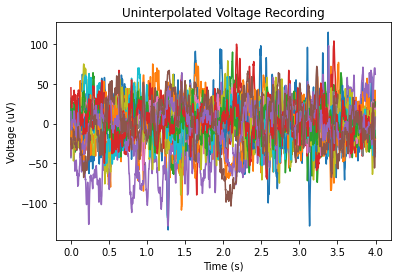

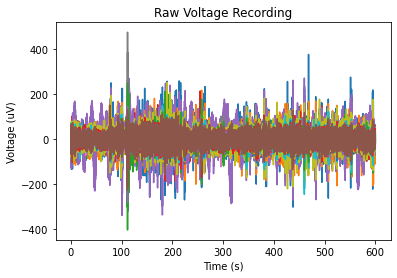

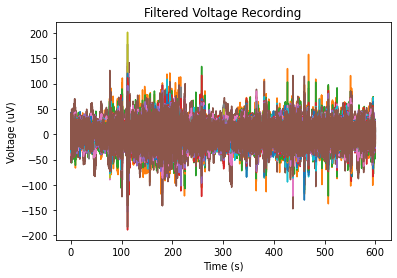

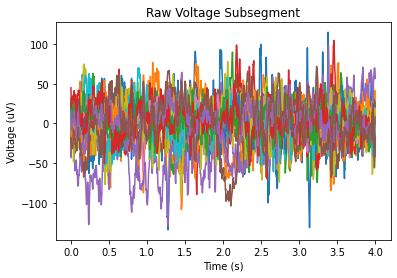

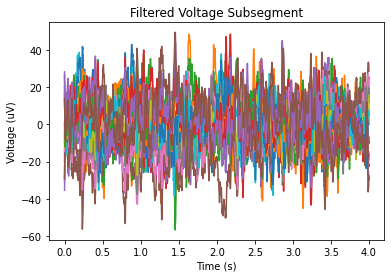

In [3]:
band_centers = [2, 6, 10, 20, 40]
basepath = os.path.dirname(os.path.realpath("__file__"))
parentpath = os.path.split(basepath)[0]
test_filepath = "seizure-prediction/Dog_1/Dog_1/Dog_1_interictal_segment_0001.mat"
path = os.path.join(parentpath, test_filepath)
varname = 'interictal_segment_1'
interictal_1 = Segment(path, varname, band_centers)


fig, ax = interictal_1.plot_uninterp(end_idx=int(interictal_1.raw_fs*4))
ax.set_title("Uninterpolated Voltage Recording")
fig, ax = interictal_1.plot_raw()
ax.set_title("Raw Voltage Recording")
fig, ax = interictal_1.plot_filt()
ax.set_title("Filtered Voltage Recording")
fig, ax = interictal_1.plot_raw(end_idx=interictal_1.fs*4)
ax.set_title("Raw Voltage Subsegment")
fig, ax = interictal_1.plot_filt(end_idx=interictal_1.fs*4)
_ = ax.set_title("Filtered Voltage Subsegment")

Visualize time-frequency representation

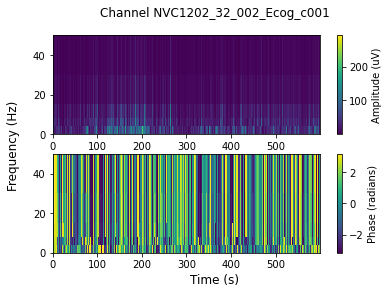

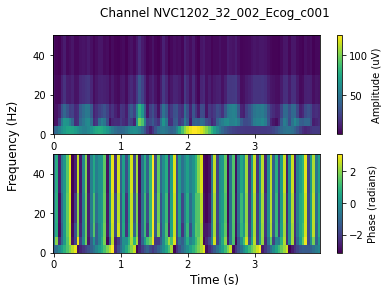

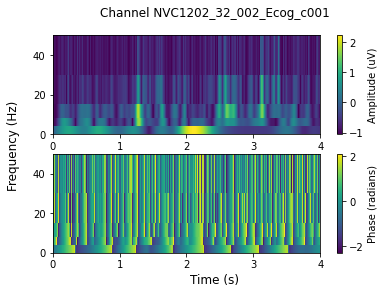

In [4]:
sample_channel = [interictal_1.channels[0]]
figs, axs = interictal_1.plot_tfr(sample_channel)
figs, axs = interictal_1.plot_tfr(sample_channel, end_idx=interictal_1.fs*4)
figs, axs = interictal_1.plot_feat(sample_channel)

In [5]:
del interictal_1 #remove sample segment from memory 

In [6]:
class EEGPreProcessor:
    """
    Class for pre-processing EEG data and extracting time-frequency representations
    """
    def __init__(self, root, saveroot, band_centers, filt_ord=1, low_cut=0.5, high_cut=50, down_freq=250, t_split=4):
        self.root = root #directory that contains raw data
        self.saveroot = saveroot #directory to save the preprocessed data
        self.seg_params = {} #segment preprocessing parameters
        self.band_centers = band_centers #frequencies for Morlet Wavelet Convolution
        self.seg_params['filt_ord'] = filt_ord #filtering order
        self.seg_params['low_cut'] = low_cut #low cutoff freq for bandpass
        self.seg_params['high_cut'] = high_cut #high cutoff freq for bandpass
        self.seg_params['down_freq'] = down_freq #downsampled frequency
        self.seg_params['t_split'] = t_split #subsegment length (s)
    
    def listsubfolders(self, root):
        """
        Helper function to list the subfolders in a directory
        """
        contents = os.listdir(root)
        subfolders = []
        for item in os.listdir(root):
            item_path = os.path.join(root, item)
            if not(os.path.isfile(item_path)):
                subfolders.append(item)
        return subfolders
    
    def __call__(self, pat_names, num_segs):
        if not(os.path.exists(self.saveroot)):
            os.mkdir(self.saveroot)
        for folder in self.listsubfolders(self.root):
            if not(folder in pat_names):
                continue
            print(folder)
            datapath = os.path.join(os.path.join(root, folder), folder)
            save_pat_path = os.path.join(saveroot, folder)
            if not(os.path.exists(save_pat_path)):
                os.mkdir(save_pat_path)
            matfiles = [file for file in os.listdir(datapath) if not("test" in file or
                                                                     ".DS_Store" in file or
                                                                     int(file[-8:-4]) > num_segs)]
            interictal_seg, preictal_seg = None, None
            for matfile in tqdm(matfiles):
                seg_path = os.path.join(datapath, matfile)
                seg_num = int(matfile[-8:-4])
                if "interictal" in matfile:
                    seg_name = "interictal_segment_"+str(seg_num)
                    seg = Segment(seg_path, seg_name, self.band_centers, **self.seg_params)
                    y = np.array(0)
                else: #preictal
                    seg_name = "preictal_segment_"+str(seg_num)
                    seg = Segment(seg_path, seg_name, self.band_centers, **self.seg_params)
                    y = np.array(1)
                save_seg_path = os.path.join(save_pat_path, seg_name)
                if not(os.path.exists(save_seg_path)):
                    os.mkdir(save_seg_path)
                for i, subseg in enumerate(seg.subsegments):
                    filepath = os.path.join(save_seg_path, str(i))
                    np.savez(filepath, X=subseg, y=y)

In [7]:
root = os.path.join(parentpath, "seizure-prediction")
saveroot = "PreProcData"
my_proc = EEGPreProcessor(root, saveroot, band_centers)

In [8]:
subs = ["Dog_2", "Dog_3", "Dog_4", "Dog_5"]
num_segs = [42, 72, 97, 30]
for sub, num_seg in zip(subs, num_segs):
    my_proc(sub, num_seg)

Dog_2


  0%|          | 0/84 [00:00<?, ?it/s]

Dog_3


  0%|          | 0/144 [00:00<?, ?it/s]

Dog_4


  0%|          | 0/194 [00:00<?, ?it/s]

Dog_5


  0%|          | 0/60 [00:00<?, ?it/s]

## CNN

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.integrate import trapz as trapz

In [9]:
batch_size = 50

Set up Dataset and Dataloader

In [10]:
class SeizureData(Dataset):
    """Seizure Prediction Dataset"""
    
    def __init__(self, root, pat_name, seg_names, n_subseg):
        self.root = root
        self.pat_name = pat_name
        self.dir_path = os.path.join(root, pat_name)
        self.seg_names = seg_names
        self.n_seg = len(seg_names)
        self.n_subseg = n_subseg
    
    def __len__(self):
        return self.n_seg*self.n_subseg
    
    def __getitem__(self, idx):
        seg_idx = idx // self.n_subseg
        subseg_idx = idx % self.n_subseg
        seg_path = os.path.join(self.dir_path, self.seg_names[seg_idx])
        subseg_path = os.path.join(seg_path, str(subseg_idx)+".npz")
        subseg = np.load(subseg_path)
        X = torch.tensor(subseg['X']).float()
        y = torch.tensor(subseg['y']).float()
        return X, y

inter_segs = [seg_name for seg_name in os.listdir("PreProcData/Patient_1") if "interictal" in seg_name]
pre_segs = [seg_name for seg_name in os.listdir("PreProcData/Patient_1") if "preictal" in seg_name]
train_segs = inter_segs[:9]+pre_segs[:9]
test_segs = inter_segs[9:18]+pre_segs[9:]
n_subseg = 150
train_dataset = SeizureData("PreProcData", "Patient_1", train_segs, n_subseg)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = SeizureData("PreProcData", "Patient_1", test_segs, n_subseg)
test_dataloader = DataLoader(test_dataset, batch_size=n_subseg, shuffle=False)

Define Model Class

In [11]:
class PredIctal(nn.Module):
    """CNN for Predicting seizure from 4s subsegments"""
    
    def __init__(
                self,
                init_w=1000,
                init_h=5,
                num_channels=30,
                width=10,
                latent_size=20,
                filter_size=5,
                pool_filter_size=(1, 10),
                pad=0,
                stride=1,
                pool_stride=2):
        #inheriting nn.Module initialization
        super(PredIctal, self).__init__()
        
        #architecture variables
        self.init_w = init_w
        self.init_h = init_h
        self.num_channels = num_channels
        self.width = width
        self.latent_size = latent_size
        self.filter_size = filter_size
        self.pool_filter_size = pool_filter_size
        self.pad = pad
        self.stride = stride
        self.pool_stride = pool_stride
        
        #output sizes
        output1_w = (init_w - filter_size + 2*pad) // stride + 1
        output1_h = (init_h - filter_size + 2*pad) // stride + 1
        output2_w = (output1_w - pool_filter_size[1]) // pool_stride + 1
        output2_h = (output1_h - pool_filter_size[0]) // pool_stride + 1
        self.linear_size = output2_w * output2_h * self.width
        
        #architecture
        self.architecture = nn.Sequential(
            nn.Conv2d(self.num_channels, self.width, self.filter_size, self.stride, self.pad),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_filter_size, self.pool_stride),
            nn.Flatten(),
            nn.Linear(self.linear_size, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.architecture(x).squeeze(1)

PredIctal()

PredIctal(
  (architecture): Sequential(
    (0): Conv2d(30, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(1, 10), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=4940, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

Training Hyperparameters

Note: $\lambda_{norm}$ is a L2 Norm Regularization parameter from [here](https://towardsdatascience.com/weight-decay-and-its-peculiar-effects-66e0aee3e7b8) 

In [12]:
learning_rate = 0.005
num_epochs = 20
epoch_nums = [epoch for epoch in range(num_epochs)]
lambda_norm = 0.05 * 200
weight_decay = lambda_norm*np.sqrt(batch_size/(num_epochs*len(train_dataset)))

Define weight initializer, training and eval loops

In [13]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
    return
def train_loop(dataloader, model, loss_fn, optimizer, print_batch=False):
    prog_bar =  tqdm(dataloader, leave=False)
    for (x, y) in prog_bar:
        #Forward Pass
        pred = model(x)
        loss = loss_fn(pred, y)
        
        #Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    prog_bar.close()
    return

def eval_loop(dataloader, model, loss_fn, thresh=0.5, seg=False):
    eval_loss, ys, preds, true_preds = 0, [], [], []
    with torch.no_grad():
        prog_bar = tqdm(dataloader, leave=False)
        for x, y in prog_bar:
            pred = model(x)
            if seg:
                seg_pred = torch.mean(pred)
                true_preds.append(seg_pred)
                seg_y = y[0]
                eval_loss += loss_fn(seg_pred, seg_y).item()
                ys.append(seg_y.item())
                if seg_pred.item() >= thresh:
                    preds.append(1)
                else:
                    preds.append(0)
            else:
                eval_loss += loss_fn(pred, y).item()
                for yi, predi in zip(y, pred):
                    ys.append(yi.item())
                    true_preds.append(predi.item())
                    if predi.item() >= thresh:
                        preds.append(1)
                    else:
                        preds.append(0)
        prog_bar.close()
    avg_loss = eval_loss / len(dataloader)
    
    ys = np.array(ys)
    preds = np.array(preds)
    acc = np.sum(ys==preds) / len(ys)
    prec, recall, f1, _ = prf(ys, preds)
    stats = avg_loss, acc, prec, recall, f1
    predsNlabels = ys, preds, true_preds
    return stats, predsNlabels

def roc_eval_loop(y, true_preds, thresholds):
    fprs, tprs = [], []
    for thresh in thresholds:
        preds = true_preds >= thresh
        true_pos = np.sum(np.logical_and(y==preds, preds==1))
        false_pos = np.sum(np.logical_and(y!=preds, preds==1))
        true_neg = np.sum(np.logical_and(y==preds, preds==0))
        false_neg = np.sum(np.logical_and(y!=preds, preds==0))
        tpr = true_pos / (false_neg + true_pos) #true positive rate
        fpr = false_pos / (false_pos + true_neg) #false positive rate
        tprs.append(tpr)
        fprs.append(fpr)
    fprs, tprs = np.flip(fprs), np.flip(tprs)
    auc = trapz(tprs, fprs)

    return tprs, fprs, auc

def plot_init(dataloader, model, idx, ch_idx, freq_idx, num_channels=15):
    with torch.no_grad():
        for x, y in dataloader:
            t = np.linspace(0, 4, x.shape[-1])
            x_amps = x[:, num_channels:, :, :]
            x_phases = x[:, :num_channels, :, :]
            sample_amp = x_amps[idx, ch_idx, freq_idx, :]
            sample_phase = x_phases[idx, ch_idx, freq_idx, :]
            sample_y = y[idx]
            pred = model(x).numpy()
            sample_pred = pred[idx]

            fig, ax = plt.subplots(2, 1)
            ax[0].plot(t, sample_amp)
            ax[1].plot(t, sample_phase)
            ax[0].set_ylabel("Normalized Amplitude")
            ax[1].set_ylabel("Normalized Phase")
            ax[0].set_xticklabels([])
            fig.supxlabel("Time (s)")
            plt.show()
            
            print("y={}, pred={}".format(sample_y, sample_pred))
            break

Initialize

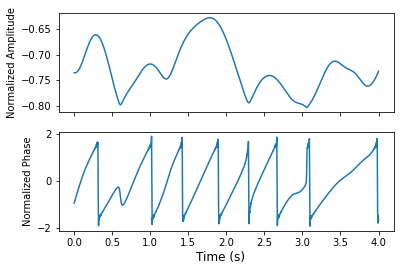

y=0.0, pred=0.672360360622406


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]


        Train:
            loss=0.899
            acc=0.47
                    interictal, preictal
          precision= 0.46,    0.48
          recall=    0.27,    0.67 
          f1=        0.34,    0.56

        Test:
            loss=0.935
            acc=0.43
                    interictal, preictal
          precision= 0.40,    0.44
          recall=    0.29,    0.56 
          f1=        0.34,    0.49

        Segment:
            loss=0.800
            acc=0.33
                    interictal, preictal
          precision= 0.00,    0.40
          recall=    0.00,    0.67
          f1=        0.00,    0.50


In [14]:
torch.random.manual_seed(1)
model = PredIctal().float()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
loss_fn = nn.BCELoss()
model.apply(weights_init)
idx, ch_idx, freq_idx = 0,0,0
plot_init(train_dataloader, model, idx, ch_idx, freq_idx)
init_train_stats, _ = eval_loop(train_dataloader, model, loss_fn)
init_test_stats, _ = eval_loop(test_dataloader, model, loss_fn)
init_seg_stats, _ = eval_loop(test_dataloader, model, loss_fn, seg=True)
def print_stats(train_stats, test_stats):
    print("""
        Train:
            loss={:.3f}
            acc={:.2f}
                    interictal, preictal
          precision= {:.2f},    {:.2f}
          recall=    {:.2f},    {:.2f} 
          f1=        {:.2f},    {:.2f}

        Test:
            loss={:.3f}
            acc={:.2f}
                    interictal, preictal
          precision= {:.2f},    {:.2f}
          recall=    {:.2f},    {:.2f} 
          f1=        {:.2f},    {:.2f}""".format(
        train_stats[0], train_stats[1], train_stats[2][0], train_stats[2][1],
        train_stats[3][0], train_stats[3][1], train_stats[4][0], train_stats[4][1],
        test_stats[0], test_stats[1], test_stats[2][0], test_stats[2][1],
        test_stats[3][0], test_stats[3][1], test_stats[4][0], test_stats[4][1]))
def print_segstats(seg_stats):
    print("""
        Segment:
            loss={:.3f}
            acc={:.2f}
                    interictal, preictal
          precision= {:.2f},    {:.2f}
          recall=    {:.2f},    {:.2f}
          f1=        {:.2f},    {:.2f}""".format(
        seg_stats[0], seg_stats[1], seg_stats[2][0], seg_stats[2][1],
        seg_stats[3][0], seg_stats[3][1], seg_stats[4][0], seg_stats[4][1]))
print_stats(init_train_stats, init_test_stats)
print_segstats(init_seg_stats)

Train

In [15]:
train_stats, test_stats = [init_train_stats], [init_test_stats]
for epoch in range(num_epochs):
    #Train
    model.train()
    train_loop(train_dataloader, model, loss_fn, optimizer)
    
    #Evaluate
    model.eval()
    train_stat, _ = eval_loop(train_dataloader, model, loss_fn)
    test_stat, _ = eval_loop(test_dataloader, model, loss_fn)

    if train_stat[0] > train_stats[-1][0]:
        scheduler.step()
        print("New Learnign Rate:", scheduler.get_last_lr()[0])
    
    print("Epoch:", epoch)
    print_stats(train_stat, test_stat)
    
    train_stats.append(train_stat)
    test_stats.append(test_stat)

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 0

        Train:
            loss=0.513
            acc=0.76
                    interictal, preictal
          precision= 0.71,    0.84
          recall=    0.87,    0.65 
          f1=        0.79,    0.73

        Test:
            loss=0.580
            acc=0.69
                    interictal, preictal
          precision= 0.68,    0.70
          recall=    0.72,    0.66 
          f1=        0.70,    0.68


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1

        Train:
            loss=0.459
            acc=0.82
                    interictal, preictal
          precision= 0.81,    0.84
          recall=    0.84,    0.80 
          f1=        0.83,    0.82

        Test:
            loss=0.615
            acc=0.68
                    interictal, preictal
          precision= 0.71,    0.65
          recall=    0.60,    0.76 
          f1=        0.65,    0.70


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2

        Train:
            loss=0.401
            acc=0.83
                    interictal, preictal
          precision= 0.85,    0.82
          recall=    0.81,    0.85 
          f1=        0.83,    0.83

        Test:
            loss=0.620
            acc=0.68
                    interictal, preictal
          precision= 0.91,    0.62
          recall=    0.41,    0.96 
          f1=        0.56,    0.75


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.0025
Epoch: 3

        Train:
            loss=0.465
            acc=0.78
                    interictal, preictal
          precision= 0.72,    0.89
          recall=    0.92,    0.64 
          f1=        0.81,    0.75

        Test:
            loss=0.406
            acc=0.76
                    interictal, preictal
          precision= 0.75,    0.77
          recall=    0.78,    0.74 
          f1=        0.76,    0.76


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4

        Train:
            loss=0.443
            acc=0.82
                    interictal, preictal
          precision= 0.90,    0.77
          recall=    0.73,    0.92 
          f1=        0.81,    0.84

        Test:
            loss=0.759
            acc=0.68
                    interictal, preictal
          precision= 0.94,    0.61
          recall=    0.38,    0.97 
          f1=        0.54,    0.75


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.00125
Epoch: 5

        Train:
            loss=0.488
            acc=0.74
                    interictal, preictal
          precision= 0.66,    0.96
          recall=    0.98,    0.51 
          f1=        0.79,    0.66

        Test:
            loss=0.383
            acc=0.77
                    interictal, preictal
          precision= 0.71,    0.88
          recall=    0.92,    0.62 
          f1=        0.80,    0.73


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6

        Train:
            loss=0.279
            acc=0.89
                    interictal, preictal
          precision= 0.88,    0.91
          recall=    0.92,    0.87 
          f1=        0.90,    0.89

        Test:
            loss=0.405
            acc=0.82
                    interictal, preictal
          precision= 0.94,    0.75
          recall=    0.69,    0.96 
          f1=        0.80,    0.84


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.000625
Epoch: 7

        Train:
            loss=0.340
            acc=0.87
                    interictal, preictal
          precision= 0.83,    0.93
          recall=    0.94,    0.80 
          f1=        0.88,    0.86

        Test:
            loss=0.379
            acc=0.82
                    interictal, preictal
          precision= 0.86,    0.78
          recall=    0.76,    0.87 
          f1=        0.81,    0.83


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8

        Train:
            loss=0.259
            acc=0.90
                    interictal, preictal
          precision= 0.89,    0.91
          recall=    0.91,    0.89 
          f1=        0.90,    0.90

        Test:
            loss=0.383
            acc=0.84
                    interictal, preictal
          precision= 0.93,    0.78
          recall=    0.73,    0.95 
          f1=        0.82,    0.85


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9

        Train:
            loss=0.256
            acc=0.91
                    interictal, preictal
          precision= 0.91,    0.91
          recall=    0.91,    0.90 
          f1=        0.91,    0.91

        Test:
            loss=0.389
            acc=0.83
                    interictal, preictal
          precision= 0.94,    0.76
          recall=    0.70,    0.95 
          f1=        0.80,    0.85


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.0003125
Epoch: 10

        Train:
            loss=0.293
            acc=0.89
                    interictal, preictal
          precision= 0.84,    0.96
          recall=    0.96,    0.82 
          f1=        0.90,    0.88

        Test:
            loss=0.313
            acc=0.87
                    interictal, preictal
          precision= 0.88,    0.87
          recall=    0.87,    0.88 
          f1=        0.87,    0.87


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 11

        Train:
            loss=0.239
            acc=0.92
                    interictal, preictal
          precision= 0.90,    0.93
          recall=    0.93,    0.90 
          f1=        0.92,    0.92

        Test:
            loss=0.344
            acc=0.85
                    interictal, preictal
          precision= 0.94,    0.79
          recall=    0.75,    0.96 
          f1=        0.84,    0.87


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.00015625
Epoch: 12

        Train:
            loss=0.240
            acc=0.92
                    interictal, preictal
          precision= 0.89,    0.95
          recall=    0.95,    0.89 
          f1=        0.92,    0.91

        Test:
            loss=0.340
            acc=0.86
                    interictal, preictal
          precision= 0.94,    0.81
          recall=    0.77,    0.95 
          f1=        0.85,    0.87


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 13

        Train:
            loss=0.237
            acc=0.91
                    interictal, preictal
          precision= 0.91,    0.92
          recall=    0.92,    0.90 
          f1=        0.91,    0.91

        Test:
            loss=0.369
            acc=0.83
                    interictal, preictal
          precision= 0.94,    0.77
          recall=    0.71,    0.95 
          f1=        0.81,    0.85


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 14

        Train:
            loss=0.230
            acc=0.92
                    interictal, preictal
          precision= 0.91,    0.94
          recall=    0.94,    0.91 
          f1=        0.93,    0.92

        Test:
            loss=0.342
            acc=0.85
                    interictal, preictal
          precision= 0.95,    0.78
          recall=    0.74,    0.96 
          f1=        0.83,    0.86


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 15

        Train:
            loss=0.229
            acc=0.92
                    interictal, preictal
          precision= 0.90,    0.94
          recall=    0.95,    0.89 
          f1=        0.92,    0.92

        Test:
            loss=0.331
            acc=0.86
                    interictal, preictal
          precision= 0.94,    0.80
          recall=    0.77,    0.95 
          f1=        0.85,    0.87


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 7.8125e-05
Epoch: 16

        Train:
            loss=0.244
            acc=0.91
                    interictal, preictal
          precision= 0.87,    0.96
          recall=    0.96,    0.86 
          f1=        0.91,    0.91

        Test:
            loss=0.297
            acc=0.89
                    interictal, preictal
          precision= 0.91,    0.87
          recall=    0.86,    0.92 
          f1=        0.88,    0.89


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 17

        Train:
            loss=0.226
            acc=0.92
                    interictal, preictal
          precision= 0.90,    0.94
          recall=    0.94,    0.89 
          f1=        0.92,    0.92

        Test:
            loss=0.341
            acc=0.85
                    interictal, preictal
          precision= 0.93,    0.80
          recall=    0.76,    0.94 
          f1=        0.84,    0.86


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 18

        Train:
            loss=0.223
            acc=0.92
                    interictal, preictal
          precision= 0.91,    0.94
          recall=    0.94,    0.91 
          f1=        0.93,    0.92

        Test:
            loss=0.344
            acc=0.85
                    interictal, preictal
          precision= 0.95,    0.79
          recall=    0.75,    0.96 
          f1=        0.84,    0.87


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 19

        Train:
            loss=0.222
            acc=0.92
                    interictal, preictal
          precision= 0.91,    0.94
          recall=    0.94,    0.91 
          f1=        0.93,    0.92

        Test:
            loss=0.348
            acc=0.85
                    interictal, preictal
          precision= 0.95,    0.78
          recall=    0.73,    0.96 
          f1=        0.83,    0.86


Evaluate Performance

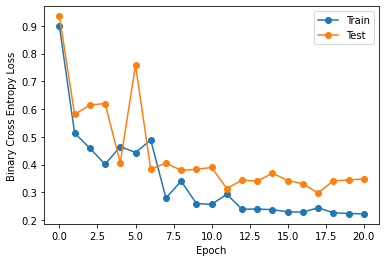

In [16]:
train_losses = np.array([train_stat[0] for train_stat in train_stats])
test_losses = np.array([test_stat[0] for test_stat in test_stats])

epoch_nums = np.arange(num_epochs+1)
plt.figure()
plt.hold = True
plt.plot(epoch_nums, train_losses, 'o-', label="Train")
plt.plot(epoch_nums, test_losses, 'o-', label="Test")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy Loss")
_ = plt.legend()

In [17]:
final_seg_stats, predsNlabels = eval_loop(test_dataloader, model, loss_fn, seg=True)
y, preds, true_preds = predsNlabels

  0%|          | 0/18 [00:00<?, ?it/s]

In [18]:
print_segstats(final_seg_stats)


        Segment:
            loss=0.291
            acc=0.89
                    interictal, preictal
          precision= 1.00,    0.82
          recall=    0.78,    1.00
          f1=        0.88,    0.90


ROC

ROCAUC= 1.0


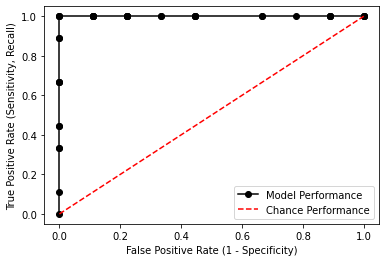

In [19]:
thresholds = np.linspace(0, 1, 41)
tprs, fprs, auc = roc_eval_loop(y, true_preds, thresholds)
print("ROCAUC=", auc)
plt.figure()
plt.hold = True
plt.plot(fprs, tprs, 'ko-')
plt.plot(fprs, fprs, 'r--')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
_ = plt.legend(["Model Performance", "Chance Performance"])

## Repeat for the rest of the Patients/Subjects

In [109]:
def generate_model(pat_name, num_segs, num_channels):
    '''
    Initialize and train CNN model to predict seizure activity from specific patient/subject
    pat_name : string
        name of patient or subject as it appears in the data directory eg. 'Patient_1'
    num_segs : int
        number of preictal segments eg. 18 for Patient 1
    num_channels : int
        number of electrode channels eg. 30 for Paitent 1
    '''
    #Setup Datasets and Dataloaders 
    batch_size = 50
    pat_dir = os.path.join("PreProcData", pat_name)
    inter_segs = [seg_name for seg_name in os.listdir(pat_dir) if "interictal" in seg_name]
    pre_segs = [seg_name for seg_name in os.listdir(pat_dir) if "preictal" in seg_name]
    train_segs = inter_segs[:num_segs//2]+pre_segs[:num_segs//2]
    test_segs = inter_segs[num_segs//2:num_segs]+pre_segs[num_segs//2:]
    n_subseg = 150
    train_dataset = SeizureData("PreProcData", pat_name, train_segs, n_subseg)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = SeizureData("PreProcData", pat_name, test_segs, n_subseg)
    test_dataloader = DataLoader(test_dataset, batch_size=n_subseg, shuffle=False)
    
    #Define Hyperparameters
    learning_rate = 0.005
    num_epochs = 20
    epoch_nums = [epoch for epoch in range(num_epochs)]
    lambda_norm = 0.05 * 200
    weight_decay = lambda_norm*np.sqrt(batch_size/(num_epochs*len(train_dataset)))
    
    #Initialize
    print("...Initializing...")
    torch.random.manual_seed(1)
    model = PredIctal(num_channels=num_channels).float()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
    loss_fn = nn.BCELoss()
    model.apply(weights_init)
    idx, ch_idx, freq_idx = 0,0,0
    plot_init(train_dataloader, model, idx, ch_idx, freq_idx, num_channels=num_channels//2)
    init_train_stats, _ = eval_loop(train_dataloader, model, loss_fn)
    init_test_stats, _ = eval_loop(test_dataloader, model, loss_fn)
    init_seg_stats, _ = eval_loop(test_dataloader, model, loss_fn, seg=True)
    print_stats(init_train_stats, init_test_stats)
    print_segstats(init_seg_stats)
    
    #Train
    print("...Training...")
    train_stats, test_stats = [init_train_stats], [init_test_stats]
    for epoch in range(num_epochs):
        #Train
        model.train()
        train_loop(train_dataloader, model, loss_fn, optimizer)

        #Evaluate
        model.eval()
        train_stat, _ = eval_loop(train_dataloader, model, loss_fn)
        test_stat, _ = eval_loop(test_dataloader, model, loss_fn)

        if train_stat[0] > train_stats[-1][0]:
            scheduler.step()
            print("New Learnign Rate:", scheduler.get_last_lr()[0])

        print("Epoch:", epoch)
        print_stats(train_stat, test_stat)

        train_stats.append(train_stat)
        test_stats.append(test_stat)
        
    #Evaluate Performance
    print("...Evaluating...")
        #Subsegment-wise loss during training
    train_losses = np.array([train_stat[0] for train_stat in train_stats])
    test_losses = np.array([test_stat[0] for test_stat in test_stats])
    epoch_nums = np.arange(num_epochs+1)
    plt.figure()
    plt.hold = True
    plt.plot(epoch_nums, train_losses, 'o-', label="Train")
    plt.plot(epoch_nums, test_losses, 'o-', label="Test")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross Entropy Loss")
    plt.legend()
    plt.title(pat_name)
        #Final Segment-wise Performance
    final_seg_stats, predsNlabels = eval_loop(test_dataloader, model, loss_fn, seg=True)
    y, preds, true_preds = predsNlabels
    print_segstats(final_seg_stats)
        #ROC
    thresholds = np.linspace(0, 1, 101)
    tprs, fprs, auc = roc_eval_loop(y, true_preds, thresholds)
    print("ROCAUC=", auc)
    plt.figure()
    plt.hold = True
    plt.plot(fprs, tprs, 'ko-')
    plt.plot(fprs, fprs, 'r--')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity, Recall)")
    plt.legend(["Model Performance", "Chance Performance"])
    _ = plt.title(pat_name)
    
    #Save Model for future use
    torch.save(model, pat_name+"Model.pt")
    
    return y, true_preds, auc 

In [110]:
def final_eval(pat_name, model):
    pat_dir = os.path.join("PreProcData", pat_name)
    inter_segs = [seg_name for seg_name in os.listdir(pat_dir) if "interictal" in seg_name]
    pre_segs = [seg_name for seg_name in os.listdir(pat_dir) if "preictal" in seg_name]
    test_segs = inter_segs[num_segs//2:num_segs]+pre_segs[num_segs//2:]
    n_subseg = 150
    test_dataset = SeizureData("PreProcData", pat_name, test_segs, n_subseg)
    test_dataloader = DataLoader(test_dataset, batch_size=n_subseg, shuffle=False)
    
    final_seg_stats, predsNlabels = eval_loop(test_dataloader, model, loss_fn, seg=True)
    y, preds, true_preds = predsNlabels
    
    thresholds = np.linspace(0, 1, 101)
    tprs, fprs, auc = roc_eval_loop(y, true_preds, thresholds)
    print("ROCAUC=", auc)
    plt.figure()
    plt.hold = True
    plt.plot(fprs, tprs, 'ko-')
    plt.plot(fprs, fprs, 'r--')
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity, Recall)")
    _ = plt.legend(["Model Performance", "Chance Performance"])
    
    return y, true_preds, auc

Patient_1
...Initializing...


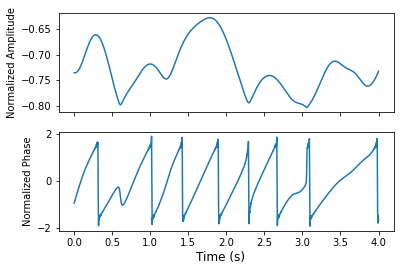

y=0.0, pred=0.672360360622406


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]


        Train:
            loss=0.899
            acc=0.47
                    interictal, preictal
          precision= 0.46,    0.48
          recall=    0.27,    0.67 
          f1=        0.34,    0.56

        Test:
            loss=0.935
            acc=0.43
                    interictal, preictal
          precision= 0.40,    0.44
          recall=    0.29,    0.56 
          f1=        0.34,    0.49

        Segment:
            loss=0.800
            acc=0.33
                    interictal, preictal
          precision= 0.00,    0.40
          recall=    0.00,    0.67
          f1=        0.00,    0.50
...Training...


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 0

        Train:
            loss=0.513
            acc=0.76
                    interictal, preictal
          precision= 0.71,    0.84
          recall=    0.87,    0.65 
          f1=        0.79,    0.73

        Test:
            loss=0.580
            acc=0.69
                    interictal, preictal
          precision= 0.68,    0.70
          recall=    0.72,    0.66 
          f1=        0.70,    0.68


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 1

        Train:
            loss=0.459
            acc=0.82
                    interictal, preictal
          precision= 0.81,    0.84
          recall=    0.84,    0.80 
          f1=        0.83,    0.82

        Test:
            loss=0.615
            acc=0.68
                    interictal, preictal
          precision= 0.71,    0.65
          recall=    0.60,    0.76 
          f1=        0.65,    0.70


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2

        Train:
            loss=0.401
            acc=0.83
                    interictal, preictal
          precision= 0.85,    0.82
          recall=    0.81,    0.85 
          f1=        0.83,    0.83

        Test:
            loss=0.620
            acc=0.68
                    interictal, preictal
          precision= 0.91,    0.62
          recall=    0.41,    0.96 
          f1=        0.56,    0.75


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.0025
Epoch: 3

        Train:
            loss=0.465
            acc=0.78
                    interictal, preictal
          precision= 0.72,    0.89
          recall=    0.92,    0.64 
          f1=        0.81,    0.75

        Test:
            loss=0.406
            acc=0.76
                    interictal, preictal
          precision= 0.75,    0.77
          recall=    0.78,    0.74 
          f1=        0.76,    0.76


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 4

        Train:
            loss=0.443
            acc=0.82
                    interictal, preictal
          precision= 0.90,    0.77
          recall=    0.73,    0.92 
          f1=        0.81,    0.84

        Test:
            loss=0.759
            acc=0.68
                    interictal, preictal
          precision= 0.94,    0.61
          recall=    0.38,    0.97 
          f1=        0.54,    0.75


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.00125
Epoch: 5

        Train:
            loss=0.488
            acc=0.74
                    interictal, preictal
          precision= 0.66,    0.96
          recall=    0.98,    0.51 
          f1=        0.79,    0.66

        Test:
            loss=0.383
            acc=0.77
                    interictal, preictal
          precision= 0.71,    0.88
          recall=    0.92,    0.62 
          f1=        0.80,    0.73


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6

        Train:
            loss=0.279
            acc=0.89
                    interictal, preictal
          precision= 0.88,    0.91
          recall=    0.92,    0.87 
          f1=        0.90,    0.89

        Test:
            loss=0.405
            acc=0.82
                    interictal, preictal
          precision= 0.94,    0.75
          recall=    0.69,    0.96 
          f1=        0.80,    0.84


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.000625
Epoch: 7

        Train:
            loss=0.340
            acc=0.87
                    interictal, preictal
          precision= 0.83,    0.93
          recall=    0.94,    0.80 
          f1=        0.88,    0.86

        Test:
            loss=0.379
            acc=0.82
                    interictal, preictal
          precision= 0.86,    0.78
          recall=    0.76,    0.87 
          f1=        0.81,    0.83


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8

        Train:
            loss=0.259
            acc=0.90
                    interictal, preictal
          precision= 0.89,    0.91
          recall=    0.91,    0.89 
          f1=        0.90,    0.90

        Test:
            loss=0.383
            acc=0.84
                    interictal, preictal
          precision= 0.93,    0.78
          recall=    0.73,    0.95 
          f1=        0.82,    0.85


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 9

        Train:
            loss=0.256
            acc=0.91
                    interictal, preictal
          precision= 0.91,    0.91
          recall=    0.91,    0.90 
          f1=        0.91,    0.91

        Test:
            loss=0.389
            acc=0.83
                    interictal, preictal
          precision= 0.94,    0.76
          recall=    0.70,    0.95 
          f1=        0.80,    0.85


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.0003125
Epoch: 10

        Train:
            loss=0.293
            acc=0.89
                    interictal, preictal
          precision= 0.84,    0.96
          recall=    0.96,    0.82 
          f1=        0.90,    0.88

        Test:
            loss=0.313
            acc=0.87
                    interictal, preictal
          precision= 0.88,    0.87
          recall=    0.87,    0.88 
          f1=        0.87,    0.87


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 11

        Train:
            loss=0.239
            acc=0.92
                    interictal, preictal
          precision= 0.90,    0.93
          recall=    0.93,    0.90 
          f1=        0.92,    0.92

        Test:
            loss=0.344
            acc=0.85
                    interictal, preictal
          precision= 0.94,    0.79
          recall=    0.75,    0.96 
          f1=        0.84,    0.87


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.00015625
Epoch: 12

        Train:
            loss=0.240
            acc=0.92
                    interictal, preictal
          precision= 0.89,    0.95
          recall=    0.95,    0.89 
          f1=        0.92,    0.91

        Test:
            loss=0.340
            acc=0.86
                    interictal, preictal
          precision= 0.94,    0.81
          recall=    0.77,    0.95 
          f1=        0.85,    0.87


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 13

        Train:
            loss=0.237
            acc=0.91
                    interictal, preictal
          precision= 0.91,    0.92
          recall=    0.92,    0.90 
          f1=        0.91,    0.91

        Test:
            loss=0.369
            acc=0.83
                    interictal, preictal
          precision= 0.94,    0.77
          recall=    0.71,    0.95 
          f1=        0.81,    0.85


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 14

        Train:
            loss=0.230
            acc=0.92
                    interictal, preictal
          precision= 0.91,    0.94
          recall=    0.94,    0.91 
          f1=        0.93,    0.92

        Test:
            loss=0.342
            acc=0.85
                    interictal, preictal
          precision= 0.95,    0.78
          recall=    0.74,    0.96 
          f1=        0.83,    0.86


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 15

        Train:
            loss=0.229
            acc=0.92
                    interictal, preictal
          precision= 0.90,    0.94
          recall=    0.95,    0.89 
          f1=        0.92,    0.92

        Test:
            loss=0.331
            acc=0.86
                    interictal, preictal
          precision= 0.94,    0.80
          recall=    0.77,    0.95 
          f1=        0.85,    0.87


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 7.8125e-05
Epoch: 16

        Train:
            loss=0.244
            acc=0.91
                    interictal, preictal
          precision= 0.87,    0.96
          recall=    0.96,    0.86 
          f1=        0.91,    0.91

        Test:
            loss=0.297
            acc=0.89
                    interictal, preictal
          precision= 0.91,    0.87
          recall=    0.86,    0.92 
          f1=        0.88,    0.89


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 17

        Train:
            loss=0.226
            acc=0.92
                    interictal, preictal
          precision= 0.90,    0.94
          recall=    0.94,    0.89 
          f1=        0.92,    0.92

        Test:
            loss=0.341
            acc=0.85
                    interictal, preictal
          precision= 0.93,    0.80
          recall=    0.76,    0.94 
          f1=        0.84,    0.86


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 18

        Train:
            loss=0.223
            acc=0.92
                    interictal, preictal
          precision= 0.91,    0.94
          recall=    0.94,    0.91 
          f1=        0.93,    0.92

        Test:
            loss=0.344
            acc=0.85
                    interictal, preictal
          precision= 0.95,    0.79
          recall=    0.75,    0.96 
          f1=        0.84,    0.87


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 19

        Train:
            loss=0.222
            acc=0.92
                    interictal, preictal
          precision= 0.91,    0.94
          recall=    0.94,    0.91 
          f1=        0.93,    0.92

        Test:
            loss=0.348
            acc=0.85
                    interictal, preictal
          precision= 0.95,    0.78
          recall=    0.73,    0.96 
          f1=        0.83,    0.86
...Evaluating...


  0%|          | 0/18 [00:00<?, ?it/s]


        Segment:
            loss=0.291
            acc=0.89
                    interictal, preictal
          precision= 1.00,    0.82
          recall=    0.78,    1.00
          f1=        0.88,    0.90
ROCAUC= 1.0
Patient_2
...Initializing...


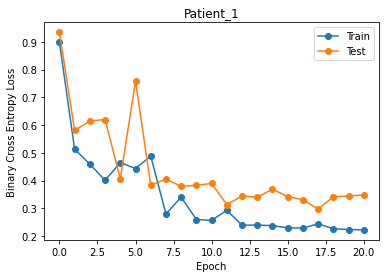

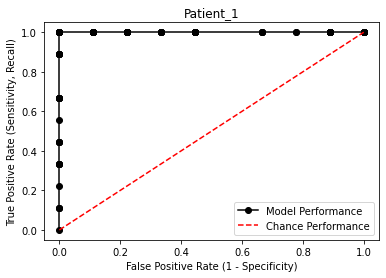

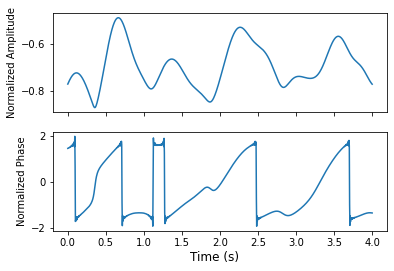

y=1.0, pred=0.9627819061279297


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]


        Train:
            loss=1.093
            acc=0.50
                    interictal, preictal
          precision= 0.52,    0.50
          recall=    0.07,    0.93 
          f1=        0.13,    0.65

        Test:
            loss=1.095
            acc=0.50
                    interictal, preictal
          precision= 0.50,    0.50
          recall=    0.08,    0.93 
          f1=        0.13,    0.65

        Segment:
            loss=0.902
            acc=0.50
                    interictal, preictal
          precision= 0.00,    0.50
          recall=    0.00,    1.00
          f1=        0.00,    0.67
...Training...


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 0

        Train:
            loss=0.660
            acc=0.58
                    interictal, preictal
          precision= 0.55,    0.66
          recall=    0.83,    0.33 
          f1=        0.66,    0.44

        Test:
            loss=0.646
            acc=0.61
                    interictal, preictal
          precision= 0.58,    0.66
          recall=    0.77,    0.44 
          f1=        0.66,    0.53


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.0025
Epoch: 1

        Train:
            loss=0.771
            acc=0.56
                    interictal, preictal
          precision= 0.64,    0.54
          recall=    0.28,    0.85 
          f1=        0.39,    0.66

        Test:
            loss=0.866
            acc=0.53
                    interictal, preictal
          precision= 0.62,    0.52
          recall=    0.18,    0.89 
          f1=        0.28,    0.66


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 2

        Train:
            loss=0.539
            acc=0.73
                    interictal, preictal
          precision= 0.75,    0.72
          recall=    0.69,    0.77 
          f1=        0.72,    0.74

        Test:
            loss=0.639
            acc=0.64
                    interictal, preictal
          precision= 0.66,    0.62
          recall=    0.57,    0.70 
          f1=        0.61,    0.66


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 3

        Train:
            loss=0.538
            acc=0.74
                    interictal, preictal
          precision= 0.67,    0.91
          recall=    0.95,    0.54 
          f1=        0.79,    0.68

        Test:
            loss=0.639
            acc=0.68
                    interictal, preictal
          precision= 0.64,    0.75
          recall=    0.83,    0.53 
          f1=        0.72,    0.62


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.00125
Epoch: 4

        Train:
            loss=0.592
            acc=0.69
                    interictal, preictal
          precision= 0.82,    0.63
          recall=    0.47,    0.90 
          f1=        0.60,    0.74

        Test:
            loss=0.789
            acc=0.62
                    interictal, preictal
          precision= 0.76,    0.58
          recall=    0.36,    0.89 
          f1=        0.49,    0.70


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 5

        Train:
            loss=0.565
            acc=0.69
                    interictal, preictal
          precision= 0.87,    0.62
          recall=    0.43,    0.94 
          f1=        0.58,    0.75

        Test:
            loss=0.785
            acc=0.61
                    interictal, preictal
          precision= 0.73,    0.57
          recall=    0.33,    0.88 
          f1=        0.46,    0.69


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 6

        Train:
            loss=0.436
            acc=0.80
                    interictal, preictal
          precision= 0.77,    0.84
          recall=    0.86,    0.75 
          f1=        0.81,    0.79

        Test:
            loss=0.630
            acc=0.70
                    interictal, preictal
          precision= 0.70,    0.70
          recall=    0.69,    0.70 
          f1=        0.70,    0.70


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.000625
Epoch: 7

        Train:
            loss=0.443
            acc=0.81
                    interictal, preictal
          precision= 0.84,    0.78
          recall=    0.76,    0.85 
          f1=        0.80,    0.81

        Test:
            loss=0.665
            acc=0.67
                    interictal, preictal
          precision= 0.72,    0.64
          recall=    0.57,    0.78 
          f1=        0.63,    0.71


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 8

        Train:
            loss=0.414
            acc=0.82
                    interictal, preictal
          precision= 0.84,    0.80
          recall=    0.78,    0.85 
          f1=        0.81,    0.82

        Test:
            loss=0.666
            acc=0.68
                    interictal, preictal
          precision= 0.72,    0.65
          recall=    0.58,    0.77 
          f1=        0.64,    0.70


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.0003125
Epoch: 9

        Train:
            loss=0.433
            acc=0.81
                    interictal, preictal
          precision= 0.75,    0.89
          recall=    0.92,    0.69 
          f1=        0.82,    0.78

        Test:
            loss=0.644
            acc=0.71
                    interictal, preictal
          precision= 0.69,    0.74
          recall=    0.77,    0.65 
          f1=        0.73,    0.69


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 10

        Train:
            loss=0.392
            acc=0.83
                    interictal, preictal
          precision= 0.79,    0.89
          recall=    0.90,    0.76 
          f1=        0.84,    0.82

        Test:
            loss=0.641
            acc=0.72
                    interictal, preictal
          precision= 0.71,    0.73
          recall=    0.75,    0.70 
          f1=        0.73,    0.72


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 11

        Train:
            loss=0.379
            acc=0.84
                    interictal, preictal
          precision= 0.84,    0.84
          recall=    0.84,    0.84 
          f1=        0.84,    0.84

        Test:
            loss=0.650
            acc=0.70
                    interictal, preictal
          precision= 0.74,    0.68
          recall=    0.64,    0.77 
          f1=        0.68,    0.72


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 12

        Train:
            loss=0.376
            acc=0.84
                    interictal, preictal
          precision= 0.85,    0.83
          recall=    0.82,    0.85 
          f1=        0.84,    0.84

        Test:
            loss=0.653
            acc=0.70
                    interictal, preictal
          precision= 0.74,    0.67
          recall=    0.62,    0.79 
          f1=        0.68,    0.73


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 0.00015625
Epoch: 13

        Train:
            loss=0.430
            acc=0.79
                    interictal, preictal
          precision= 0.92,    0.72
          recall=    0.63,    0.95 
          f1=        0.75,    0.82

        Test:
            loss=0.742
            acc=0.65
                    interictal, preictal
          precision= 0.76,    0.61
          recall=    0.45,    0.86 
          f1=        0.56,    0.71


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 14

        Train:
            loss=0.389
            acc=0.84
                    interictal, preictal
          precision= 0.78,    0.93
          recall=    0.94,    0.73 
          f1=        0.85,    0.82

        Test:
            loss=0.633
            acc=0.73
                    interictal, preictal
          precision= 0.71,    0.76
          recall=    0.79,    0.67 
          f1=        0.75,    0.71


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 15

        Train:
            loss=0.371
            acc=0.84
                    interictal, preictal
          precision= 0.83,    0.85
          recall=    0.85,    0.83 
          f1=        0.84,    0.84

        Test:
            loss=0.657
            acc=0.71
                    interictal, preictal
          precision= 0.74,    0.69
          recall=    0.66,    0.76 
          f1=        0.70,    0.73


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 16

        Train:
            loss=0.365
            acc=0.84
                    interictal, preictal
          precision= 0.84,    0.85
          recall=    0.85,    0.84 
          f1=        0.84,    0.84

        Test:
            loss=0.647
            acc=0.71
                    interictal, preictal
          precision= 0.74,    0.69
          recall=    0.65,    0.77 
          f1=        0.69,    0.73


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

New Learnign Rate: 7.8125e-05
Epoch: 17

        Train:
            loss=0.369
            acc=0.84
                    interictal, preictal
          precision= 0.86,    0.82
          recall=    0.81,    0.87 
          f1=        0.83,    0.84

        Test:
            loss=0.665
            acc=0.70
                    interictal, preictal
          precision= 0.74,    0.67
          recall=    0.61,    0.79 
          f1=        0.67,    0.72


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 18

        Train:
            loss=0.359
            acc=0.85
                    interictal, preictal
          precision= 0.82,    0.89
          recall=    0.90,    0.80 
          f1=        0.86,    0.84

        Test:
            loss=0.628
            acc=0.72
                    interictal, preictal
          precision= 0.73,    0.72
          recall=    0.71,    0.74 
          f1=        0.72,    0.73


  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Epoch: 19

        Train:
            loss=0.357
            acc=0.85
                    interictal, preictal
          precision= 0.82,    0.88
          recall=    0.89,    0.81 
          f1=        0.86,    0.85

        Test:
            loss=0.631
            acc=0.72
                    interictal, preictal
          precision= 0.73,    0.71
          recall=    0.70,    0.75 
          f1=        0.72,    0.73
...Evaluating...


  0%|          | 0/18 [00:00<?, ?it/s]


        Segment:
            loss=0.473
            acc=0.78
                    interictal, preictal
          precision= 0.78,    0.78
          recall=    0.78,    0.78
          f1=        0.78,    0.78
ROCAUC= 0.8765432098765432
Dog_1
...Initializing...


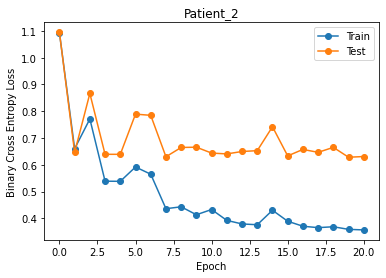

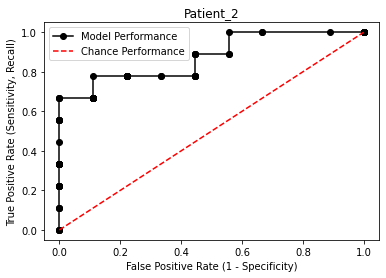

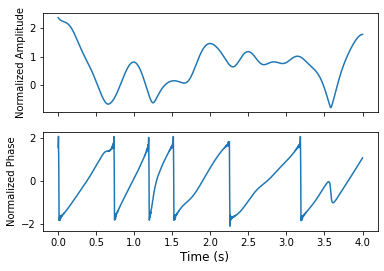

y=1.0, pred=0.613321840763092


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]


        Train:
            loss=1.071
            acc=0.50
                    interictal, preictal
          precision= 0.50,    0.50
          recall=    0.14,    0.86 
          f1=        0.22,    0.63

        Test:
            loss=1.102
            acc=0.49
                    interictal, preictal
          precision= 0.45,    0.49
          recall=    0.12,    0.85 
          f1=        0.19,    0.62

        Segment:
            loss=0.875
            acc=0.50
                    interictal, preictal
          precision= 0.00,    0.50
          recall=    0.00,    1.00
          f1=        0.00,    0.67
...Training...


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 0

        Train:
            loss=0.658
            acc=0.61
                    interictal, preictal
          precision= 0.60,    0.62
          recall=    0.65,    0.56 
          f1=        0.63,    0.59

        Test:
            loss=0.649
            acc=0.60
                    interictal, preictal
          precision= 0.59,    0.61
          recall=    0.65,    0.55 
          f1=        0.62,    0.58


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 1

        Train:
            loss=0.641
            acc=0.63
                    interictal, preictal
          precision= 0.62,    0.64
          recall=    0.67,    0.59 
          f1=        0.64,    0.62

        Test:
            loss=0.620
            acc=0.65
                    interictal, preictal
          precision= 0.63,    0.66
          recall=    0.70,    0.59 
          f1=        0.67,    0.63


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

New Learnign Rate: 0.0025
Epoch: 2

        Train:
            loss=0.710
            acc=0.51
                    interictal, preictal
          precision= 0.53,    0.51
          recall=    0.26,    0.77 
          f1=        0.35,    0.61

        Test:
            loss=0.728
            acc=0.50
                    interictal, preictal
          precision= 0.49,    0.50
          recall=    0.22,    0.77 
          f1=        0.31,    0.60


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 3

        Train:
            loss=0.578
            acc=0.73
                    interictal, preictal
          precision= 0.71,    0.75
          recall=    0.77,    0.68 
          f1=        0.74,    0.71

        Test:
            loss=0.570
            acc=0.69
                    interictal, preictal
          precision= 0.67,    0.72
          recall=    0.76,    0.63 
          f1=        0.71,    0.67


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

New Learnign Rate: 0.00125
Epoch: 4

        Train:
            loss=0.597
            acc=0.67
                    interictal, preictal
          precision= 0.66,    0.70
          recall=    0.73,    0.62 
          f1=        0.69,    0.66

        Test:
            loss=0.565
            acc=0.67
                    interictal, preictal
          precision= 0.65,    0.70
          recall=    0.74,    0.59 
          f1=        0.69,    0.64


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 5

        Train:
            loss=0.541
            acc=0.73
                    interictal, preictal
          precision= 0.75,    0.72
          recall=    0.70,    0.77 
          f1=        0.72,    0.74

        Test:
            loss=0.595
            acc=0.67
                    interictal, preictal
          precision= 0.67,    0.66
          recall=    0.66,    0.67 
          f1=        0.66,    0.67


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

New Learnign Rate: 0.000625
Epoch: 6

        Train:
            loss=0.581
            acc=0.68
                    interictal, preictal
          precision= 0.63,    0.81
          recall=    0.89,    0.48 
          f1=        0.74,    0.60

        Test:
            loss=0.618
            acc=0.66
                    interictal, preictal
          precision= 0.61,    0.78
          recall=    0.88,    0.43 
          f1=        0.72,    0.56


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 7

        Train:
            loss=0.479
            acc=0.78
                    interictal, preictal
          precision= 0.87,    0.72
          recall=    0.65,    0.91 
          f1=        0.75,    0.80

        Test:
            loss=0.561
            acc=0.73
                    interictal, preictal
          precision= 0.79,    0.69
          recall=    0.63,    0.83 
          f1=        0.70,    0.76


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

New Learnign Rate: 0.0003125
Epoch: 8

        Train:
            loss=0.504
            acc=0.75
                    interictal, preictal
          precision= 0.70,    0.83
          recall=    0.87,    0.63 
          f1=        0.77,    0.71

        Test:
            loss=0.586
            acc=0.68
                    interictal, preictal
          precision= 0.63,    0.76
          recall=    0.84,    0.51 
          f1=        0.72,    0.61


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 9

        Train:
            loss=0.444
            acc=0.81
                    interictal, preictal
          precision= 0.83,    0.79
          recall=    0.78,    0.84 
          f1=        0.81,    0.82

        Test:
            loss=0.555
            acc=0.72
                    interictal, preictal
          precision= 0.72,    0.72
          recall=    0.72,    0.72 
          f1=        0.72,    0.72


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 10

        Train:
            loss=0.442
            acc=0.81
                    interictal, preictal
          precision= 0.80,    0.82
          recall=    0.83,    0.80 
          f1=        0.82,    0.81

        Test:
            loss=0.550
            acc=0.73
                    interictal, preictal
          precision= 0.70,    0.75
          recall=    0.78,    0.68 
          f1=        0.74,    0.71


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 11

        Train:
            loss=0.425
            acc=0.82
                    interictal, preictal
          precision= 0.83,    0.81
          recall=    0.81,    0.83 
          f1=        0.82,    0.82

        Test:
            loss=0.542
            acc=0.74
                    interictal, preictal
          precision= 0.73,    0.74
          recall=    0.75,    0.72 
          f1=        0.74,    0.73


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

New Learnign Rate: 0.00015625
Epoch: 12

        Train:
            loss=0.433
            acc=0.81
                    interictal, preictal
          precision= 0.78,    0.86
          recall=    0.87,    0.75 
          f1=        0.82,    0.80

        Test:
            loss=0.562
            acc=0.71
                    interictal, preictal
          precision= 0.68,    0.78
          recall=    0.82,    0.60 
          f1=        0.74,    0.68


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 13

        Train:
            loss=0.430
            acc=0.81
                    interictal, preictal
          precision= 0.77,    0.87
          recall=    0.89,    0.73 
          f1=        0.82,    0.80

        Test:
            loss=0.552
            acc=0.71
                    interictal, preictal
          precision= 0.67,    0.78
          recall=    0.83,    0.59 
          f1=        0.74,    0.67


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 14

        Train:
            loss=0.413
            acc=0.83
                    interictal, preictal
          precision= 0.84,    0.82
          recall=    0.82,    0.84 
          f1=        0.83,    0.83

        Test:
            loss=0.536
            acc=0.74
                    interictal, preictal
          precision= 0.74,    0.75
          recall=    0.76,    0.73 
          f1=        0.75,    0.74


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 15

        Train:
            loss=0.408
            acc=0.83
                    interictal, preictal
          precision= 0.84,    0.82
          recall=    0.82,    0.84 
          f1=        0.83,    0.83

        Test:
            loss=0.535
            acc=0.74
                    interictal, preictal
          precision= 0.73,    0.75
          recall=    0.76,    0.72 
          f1=        0.75,    0.73


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 16

        Train:
            loss=0.404
            acc=0.84
                    interictal, preictal
          precision= 0.84,    0.84
          recall=    0.83,    0.84 
          f1=        0.84,    0.84

        Test:
            loss=0.524
            acc=0.74
                    interictal, preictal
          precision= 0.73,    0.76
          recall=    0.77,    0.72 
          f1=        0.75,    0.74


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

New Learnign Rate: 7.8125e-05
Epoch: 17

        Train:
            loss=0.437
            acc=0.79
                    interictal, preictal
          precision= 0.73,    0.91
          recall=    0.94,    0.65 
          f1=        0.82,    0.76

        Test:
            loss=0.590
            acc=0.68
                    interictal, preictal
          precision= 0.63,    0.79
          recall=    0.87,    0.50 
          f1=        0.73,    0.61


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 18

        Train:
            loss=0.399
            acc=0.84
                    interictal, preictal
          precision= 0.83,    0.85
          recall=    0.86,    0.83 
          f1=        0.85,    0.84

        Test:
            loss=0.540
            acc=0.74
                    interictal, preictal
          precision= 0.71,    0.77
          recall=    0.80,    0.68 
          f1=        0.75,    0.72


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch: 19

        Train:
            loss=0.393
            acc=0.84
                    interictal, preictal
          precision= 0.86,    0.83
          recall=    0.82,    0.87 
          f1=        0.84,    0.85

        Test:
            loss=0.536
            acc=0.74
                    interictal, preictal
          precision= 0.73,    0.75
          recall=    0.76,    0.73 
          f1=        0.74,    0.74
...Evaluating...


  0%|          | 0/24 [00:00<?, ?it/s]


        Segment:
            loss=0.424
            acc=0.96
                    interictal, preictal
          precision= 0.92,    1.00
          recall=    1.00,    0.92
          f1=        0.96,    0.96
ROCAUC= 1.0
Dog_2
...Initializing...


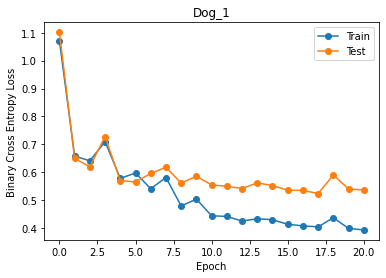

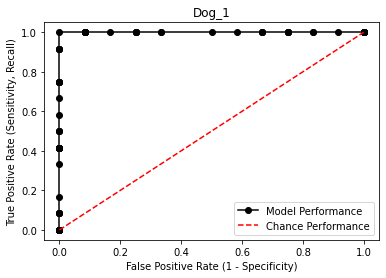

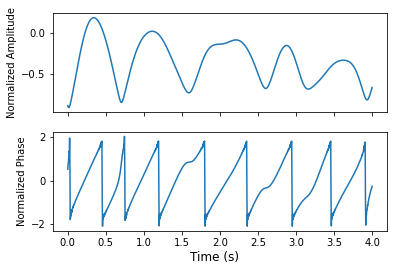

y=1.0, pred=0.9554129838943481


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]


        Train:
            loss=1.010
            acc=0.51
                    interictal, preictal
          precision= 0.52,    0.50
          recall=    0.17,    0.84 
          f1=        0.26,    0.63

        Test:
            loss=0.989
            acc=0.51
                    interictal, preictal
          precision= 0.52,    0.50
          recall=    0.18,    0.84 
          f1=        0.27,    0.63

        Segment:
            loss=0.783
            acc=0.50
                    interictal, preictal
          precision= 0.00,    0.50
          recall=    0.00,    1.00
          f1=        0.00,    0.67
...Training...


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 0

        Train:
            loss=0.637
            acc=0.66
                    interictal, preictal
          precision= 0.69,    0.64
          recall=    0.58,    0.74 
          f1=        0.63,    0.69

        Test:
            loss=0.616
            acc=0.67
                    interictal, preictal
          precision= 0.70,    0.65
          recall=    0.60,    0.75 
          f1=        0.65,    0.70


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 1

        Train:
            loss=0.538
            acc=0.72
                    interictal, preictal
          precision= 0.77,    0.68
          recall=    0.62,    0.82 
          f1=        0.69,    0.74

        Test:
            loss=0.501
            acc=0.74
                    interictal, preictal
          precision= 0.81,    0.70
          recall=    0.63,    0.85 
          f1=        0.71,    0.77


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

New Learnign Rate: 0.0025
Epoch: 2

        Train:
            loss=0.621
            acc=0.65
                    interictal, preictal
          precision= 0.73,    0.61
          recall=    0.48,    0.82 
          f1=        0.58,    0.70

        Test:
            loss=0.606
            acc=0.65
                    interictal, preictal
          precision= 0.74,    0.61
          recall=    0.47,    0.83 
          f1=        0.58,    0.71


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 3

        Train:
            loss=0.523
            acc=0.71
                    interictal, preictal
          precision= 0.68,    0.77
          recall=    0.82,    0.61 
          f1=        0.74,    0.68

        Test:
            loss=0.506
            acc=0.74
                    interictal, preictal
          precision= 0.69,    0.82
          recall=    0.87,    0.61 
          f1=        0.77,    0.70


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 4

        Train:
            loss=0.521
            acc=0.72
                    interictal, preictal
          precision= 0.67,    0.83
          recall=    0.89,    0.56 
          f1=        0.76,    0.67

        Test:
            loss=0.525
            acc=0.72
                    interictal, preictal
          precision= 0.66,    0.86
          recall=    0.92,    0.53 
          f1=        0.77,    0.66


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

New Learnign Rate: 0.00125
Epoch: 5

        Train:
            loss=0.637
            acc=0.62
                    interictal, preictal
          precision= 0.57,    0.91
          recall=    0.97,    0.27 
          f1=        0.72,    0.42

        Test:
            loss=0.666
            acc=0.63
                    interictal, preictal
          precision= 0.58,    0.95
          recall=    0.99,    0.27 
          f1=        0.73,    0.42


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 6

        Train:
            loss=0.463
            acc=0.79
                    interictal, preictal
          precision= 0.81,    0.77
          recall=    0.76,    0.82 
          f1=        0.78,    0.80

        Test:
            loss=0.473
            acc=0.79
                    interictal, preictal
          precision= 0.78,    0.79
          recall=    0.80,    0.78 
          f1=        0.79,    0.78


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

New Learnign Rate: 0.000625
Epoch: 7

        Train:
            loss=0.465
            acc=0.77
                    interictal, preictal
          precision= 0.90,    0.71
          recall=    0.62,    0.93 
          f1=        0.73,    0.81

        Test:
            loss=0.451
            acc=0.78
                    interictal, preictal
          precision= 0.88,    0.72
          recall=    0.64,    0.91 
          f1=        0.74,    0.80


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 8

        Train:
            loss=0.445
            acc=0.79
                    interictal, preictal
          precision= 0.93,    0.71
          recall=    0.62,    0.96 
          f1=        0.74,    0.82

        Test:
            loss=0.450
            acc=0.78
                    interictal, preictal
          precision= 0.90,    0.72
          recall=    0.63,    0.93 
          f1=        0.74,    0.81


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 9

        Train:
            loss=0.435
            acc=0.79
                    interictal, preictal
          precision= 0.93,    0.72
          recall=    0.64,    0.95 
          f1=        0.75,    0.82

        Test:
            loss=0.439
            acc=0.79
                    interictal, preictal
          precision= 0.89,    0.73
          recall=    0.66,    0.92 
          f1=        0.76,    0.81


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 10

        Train:
            loss=0.402
            acc=0.82
                    interictal, preictal
          precision= 0.87,    0.78
          recall=    0.75,    0.89 
          f1=        0.81,    0.83

        Test:
            loss=0.418
            acc=0.81
                    interictal, preictal
          precision= 0.82,    0.80
          recall=    0.79,    0.83 
          f1=        0.80,    0.81


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 11

        Train:
            loss=0.400
            acc=0.82
                    interictal, preictal
          precision= 0.82,    0.81
          recall=    0.81,    0.82 
          f1=        0.82,    0.82

        Test:
            loss=0.419
            acc=0.80
                    interictal, preictal
          precision= 0.78,    0.83
          recall=    0.84,    0.76 
          f1=        0.81,    0.79


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

New Learnign Rate: 0.0003125
Epoch: 12

        Train:
            loss=0.434
            acc=0.79
                    interictal, preictal
          precision= 0.94,    0.72
          recall=    0.63,    0.96 
          f1=        0.75,    0.82

        Test:
            loss=0.452
            acc=0.78
                    interictal, preictal
          precision= 0.90,    0.71
          recall=    0.63,    0.93 
          f1=        0.74,    0.81


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 13

        Train:
            loss=0.393
            acc=0.82
                    interictal, preictal
          precision= 0.91,    0.77
          recall=    0.72,    0.93 
          f1=        0.80,    0.84

        Test:
            loss=0.414
            acc=0.81
                    interictal, preictal
          precision= 0.85,    0.78
          recall=    0.75,    0.87 
          f1=        0.80,    0.82


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 14

        Train:
            loss=0.387
            acc=0.83
                    interictal, preictal
          precision= 0.88,    0.79
          recall=    0.76,    0.90 
          f1=        0.82,    0.84

        Test:
            loss=0.405
            acc=0.81
                    interictal, preictal
          precision= 0.83,    0.80
          recall=    0.79,    0.84 
          f1=        0.81,    0.82


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

New Learnign Rate: 0.00015625
Epoch: 15

        Train:
            loss=0.395
            acc=0.82
                    interictal, preictal
          precision= 0.79,    0.85
          recall=    0.86,    0.78 
          f1=        0.83,    0.81

        Test:
            loss=0.434
            acc=0.79
                    interictal, preictal
          precision= 0.74,    0.86
          recall=    0.88,    0.69 
          f1=        0.81,    0.77


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 16

        Train:
            loss=0.375
            acc=0.84
                    interictal, preictal
          precision= 0.88,    0.81
          recall=    0.79,    0.89 
          f1=        0.83,    0.85

        Test:
            loss=0.401
            acc=0.82
                    interictal, preictal
          precision= 0.82,    0.81
          recall=    0.81,    0.83 
          f1=        0.82,    0.82


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 17

        Train:
            loss=0.374
            acc=0.84
                    interictal, preictal
          precision= 0.88,    0.81
          recall=    0.79,    0.89 
          f1=        0.83,    0.85

        Test:
            loss=0.399
            acc=0.82
                    interictal, preictal
          precision= 0.82,    0.81
          recall=    0.81,    0.83 
          f1=        0.82,    0.82


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

New Learnign Rate: 7.8125e-05
Epoch: 18

        Train:
            loss=0.375
            acc=0.84
                    interictal, preictal
          precision= 0.83,    0.84
          recall=    0.85,    0.83 
          f1=        0.84,    0.84

        Test:
            loss=0.406
            acc=0.81
                    interictal, preictal
          precision= 0.78,    0.84
          recall=    0.86,    0.75 
          f1=        0.82,    0.80


  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch: 19

        Train:
            loss=0.374
            acc=0.84
                    interictal, preictal
          precision= 0.88,    0.80
          recall=    0.78,    0.90 
          f1=        0.83,    0.85

        Test:
            loss=0.398
            acc=0.82
                    interictal, preictal
          precision= 0.83,    0.81
          recall=    0.80,    0.84 
          f1=        0.82,    0.83
...Evaluating...


  0%|          | 0/42 [00:00<?, ?it/s]


        Segment:
            loss=0.340
            acc=0.90
                    interictal, preictal
          precision= 0.95,    0.87
          recall=    0.86,    0.95
          f1=        0.90,    0.91
ROCAUC= 0.9931972789115646
Dog_3
...Initializing...


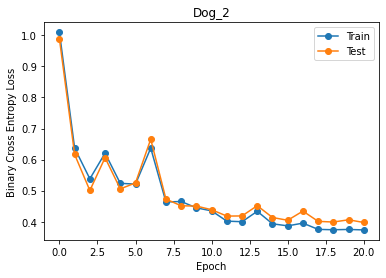

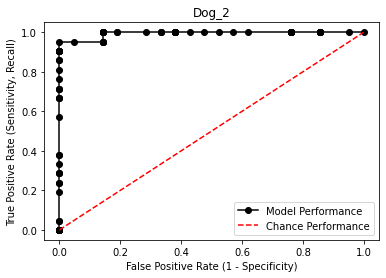

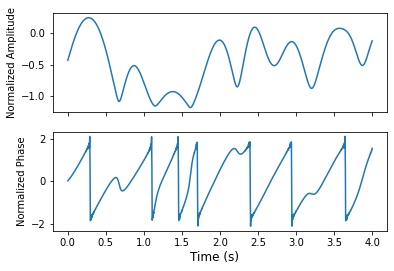

y=1.0, pred=0.9007955193519592


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]


        Train:
            loss=1.034
            acc=0.49
                    interictal, preictal
          precision= 0.47,    0.50
          recall=    0.14,    0.85 
          f1=        0.21,    0.63

        Test:
            loss=1.021
            acc=0.50
                    interictal, preictal
          precision= 0.49,    0.50
          recall=    0.14,    0.85 
          f1=        0.22,    0.63

        Segment:
            loss=0.825
            acc=0.50
                    interictal, preictal
          precision= 0.00,    0.50
          recall=    0.00,    1.00
          f1=        0.00,    0.67
...Training...


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 0

        Train:
            loss=0.523
            acc=0.75
                    interictal, preictal
          precision= 0.72,    0.79
          recall=    0.83,    0.68 
          f1=        0.77,    0.73

        Test:
            loss=0.629
            acc=0.63
                    interictal, preictal
          precision= 0.60,    0.70
          recall=    0.79,    0.48 
          f1=        0.68,    0.57


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

New Learnign Rate: 0.0025
Epoch: 1

        Train:
            loss=0.569
            acc=0.74
                    interictal, preictal
          precision= 0.82,    0.69
          recall=    0.61,    0.86 
          f1=        0.70,    0.77

        Test:
            loss=0.653
            acc=0.65
                    interictal, preictal
          precision= 0.71,    0.62
          recall=    0.50,    0.80 
          f1=        0.59,    0.70


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 2

        Train:
            loss=0.458
            acc=0.78
                    interictal, preictal
          precision= 0.74,    0.83
          recall=    0.85,    0.70 
          f1=        0.79,    0.76

        Test:
            loss=0.590
            acc=0.66
                    interictal, preictal
          precision= 0.63,    0.71
          recall=    0.77,    0.55 
          f1=        0.70,    0.62


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 3

        Train:
            loss=0.401
            acc=0.80
                    interictal, preictal
          precision= 0.76,    0.86
          recall=    0.88,    0.72 
          f1=        0.81,    0.78

        Test:
            loss=0.564
            acc=0.69
                    interictal, preictal
          precision= 0.64,    0.76
          recall=    0.83,    0.54 
          f1=        0.73,    0.63


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

New Learnign Rate: 0.00125
Epoch: 4

        Train:
            loss=0.418
            acc=0.79
                    interictal, preictal
          precision= 0.75,    0.86
          recall=    0.88,    0.70 
          f1=        0.81,    0.77

        Test:
            loss=0.569
            acc=0.68
                    interictal, preictal
          precision= 0.64,    0.76
          recall=    0.83,    0.53 
          f1=        0.72,    0.62


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 5

        Train:
            loss=0.376
            acc=0.82
                    interictal, preictal
          precision= 0.83,    0.81
          recall=    0.80,    0.84 
          f1=        0.82,    0.82

        Test:
            loss=0.545
            acc=0.71
                    interictal, preictal
          precision= 0.71,    0.70
          recall=    0.70,    0.72 
          f1=        0.71,    0.71


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

New Learnign Rate: 0.000625
Epoch: 6

        Train:
            loss=0.401
            acc=0.80
                    interictal, preictal
          precision= 0.74,    0.88
          recall=    0.91,    0.68 
          f1=        0.82,    0.77

        Test:
            loss=0.581
            acc=0.69
                    interictal, preictal
          precision= 0.64,    0.78
          recall=    0.85,    0.52 
          f1=        0.73,    0.62


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 7

        Train:
            loss=0.368
            acc=0.83
                    interictal, preictal
          precision= 0.88,    0.80
          recall=    0.77,    0.89 
          f1=        0.82,    0.84

        Test:
            loss=0.535
            acc=0.72
                    interictal, preictal
          precision= 0.76,    0.69
          recall=    0.64,    0.80 
          f1=        0.69,    0.74


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

New Learnign Rate: 0.0003125
Epoch: 8

        Train:
            loss=0.395
            acc=0.81
                    interictal, preictal
          precision= 0.91,    0.75
          recall=    0.69,    0.93 
          f1=        0.79,    0.83

        Test:
            loss=0.568
            acc=0.71
                    interictal, preictal
          precision= 0.79,    0.66
          recall=    0.55,    0.86 
          f1=        0.65,    0.74


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 9

        Train:
            loss=0.342
            acc=0.84
                    interictal, preictal
          precision= 0.83,    0.86
          recall=    0.87,    0.82 
          f1=        0.85,    0.84

        Test:
            loss=0.522
            acc=0.73
                    interictal, preictal
          precision= 0.71,    0.75
          recall=    0.77,    0.68 
          f1=        0.74,    0.71


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

New Learnign Rate: 0.00015625
Epoch: 10

        Train:
            loss=0.361
            acc=0.84
                    interictal, preictal
          precision= 0.90,    0.79
          recall=    0.76,    0.91 
          f1=        0.82,    0.85

        Test:
            loss=0.531
            acc=0.72
                    interictal, preictal
          precision= 0.78,    0.68
          recall=    0.62,    0.83 
          f1=        0.69,    0.75


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 11

        Train:
            loss=0.342
            acc=0.84
                    interictal, preictal
          precision= 0.82,    0.87
          recall=    0.88,    0.80 
          f1=        0.85,    0.84

        Test:
            loss=0.530
            acc=0.72
                    interictal, preictal
          precision= 0.69,    0.76
          recall=    0.79,    0.64 
          f1=        0.74,    0.69


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 12

        Train:
            loss=0.335
            acc=0.85
                    interictal, preictal
          precision= 0.83,    0.86
          recall=    0.87,    0.82 
          f1=        0.85,    0.84

        Test:
            loss=0.515
            acc=0.73
                    interictal, preictal
          precision= 0.71,    0.75
          recall=    0.78,    0.68 
          f1=        0.74,    0.72


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

New Learnign Rate: 7.8125e-05
Epoch: 13

        Train:
            loss=0.353
            acc=0.83
                    interictal, preictal
          precision= 0.78,    0.91
          recall=    0.92,    0.74 
          f1=        0.85,    0.81

        Test:
            loss=0.546
            acc=0.71
                    interictal, preictal
          precision= 0.66,    0.79
          recall=    0.85,    0.56 
          f1=        0.74,    0.66


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 14

        Train:
            loss=0.333
            acc=0.85
                    interictal, preictal
          precision= 0.85,    0.84
          recall=    0.84,    0.86 
          f1=        0.85,    0.85

        Test:
            loss=0.514
            acc=0.73
                    interictal, preictal
          precision= 0.73,    0.73
          recall=    0.73,    0.73 
          f1=        0.73,    0.73


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 15

        Train:
            loss=0.333
            acc=0.85
                    interictal, preictal
          precision= 0.87,    0.83
          recall=    0.82,    0.88 
          f1=        0.85,    0.85

        Test:
            loss=0.508
            acc=0.74
                    interictal, preictal
          precision= 0.75,    0.72
          recall=    0.70,    0.77 
          f1=        0.73,    0.75


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

New Learnign Rate: 3.90625e-05
Epoch: 16

        Train:
            loss=0.335
            acc=0.85
                    interictal, preictal
          precision= 0.82,    0.88
          recall=    0.90,    0.80 
          f1=        0.85,    0.84

        Test:
            loss=0.519
            acc=0.73
                    interictal, preictal
          precision= 0.70,    0.77
          recall=    0.81,    0.65 
          f1=        0.75,    0.70


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 17

        Train:
            loss=0.329
            acc=0.85
                    interictal, preictal
          precision= 0.85,    0.85
          recall=    0.85,    0.85 
          f1=        0.85,    0.85

        Test:
            loss=0.509
            acc=0.73
                    interictal, preictal
          precision= 0.73,    0.74
          recall=    0.75,    0.72 
          f1=        0.74,    0.73


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

New Learnign Rate: 1.953125e-05
Epoch: 18

        Train:
            loss=0.330
            acc=0.85
                    interictal, preictal
          precision= 0.84,    0.87
          recall=    0.87,    0.83 
          f1=        0.85,    0.85

        Test:
            loss=0.514
            acc=0.73
                    interictal, preictal
          precision= 0.71,    0.75
          recall=    0.77,    0.69 
          f1=        0.74,    0.72


  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/216 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

Epoch: 19

        Train:
            loss=0.330
            acc=0.85
                    interictal, preictal
          precision= 0.86,    0.84
          recall=    0.84,    0.86 
          f1=        0.85,    0.85

        Test:
            loss=0.509
            acc=0.74
                    interictal, preictal
          precision= 0.74,    0.73
          recall=    0.73,    0.75 
          f1=        0.73,    0.74
...Evaluating...


  0%|          | 0/72 [00:00<?, ?it/s]


        Segment:
            loss=0.443
            acc=0.78
                    interictal, preictal
          precision= 0.79,    0.76
          recall=    0.75,    0.81
          f1=        0.77,    0.78
ROCAUC= 0.9066358024691358
Dog_4
...Initializing...


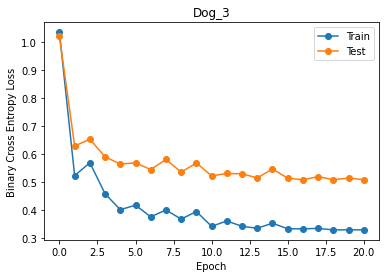

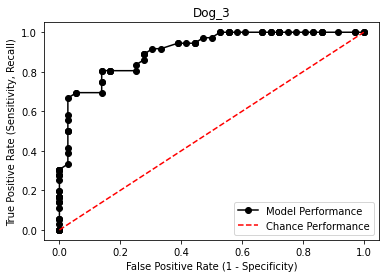

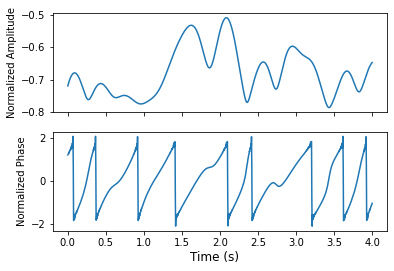

y=0.0, pred=0.9196329116821289


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]


        Train:
            loss=1.009
            acc=0.51
                    interictal, preictal
          precision= 0.52,    0.50
          recall=    0.17,    0.85 
          f1=        0.25,    0.63

        Test:
            loss=1.031
            acc=0.50
                    interictal, preictal
          precision= 0.49,    0.50
          recall=    0.16,    0.84 
          f1=        0.24,    0.62

        Segment:
            loss=0.816
            acc=0.50
                    interictal, preictal
          precision= 0.00,    0.50
          recall=    0.00,    1.00
          f1=        0.00,    0.67
...Training...


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 0

        Train:
            loss=0.629
            acc=0.64
                    interictal, preictal
          precision= 0.81,    0.59
          recall=    0.36,    0.92 
          f1=        0.50,    0.72

        Test:
            loss=0.621
            acc=0.66
                    interictal, preictal
          precision= 0.85,    0.60
          recall=    0.38,    0.93 
          f1=        0.53,    0.73


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 1

        Train:
            loss=0.617
            acc=0.68
                    interictal, preictal
          precision= 0.71,    0.66
          recall=    0.62,    0.74 
          f1=        0.66,    0.70

        Test:
            loss=0.590
            acc=0.74
                    interictal, preictal
          precision= 0.77,    0.72
          recall=    0.68,    0.80 
          f1=        0.73,    0.76


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 2

        Train:
            loss=0.608
            acc=0.67
                    interictal, preictal
          precision= 0.65,    0.69
          recall=    0.73,    0.60 
          f1=        0.69,    0.64

        Test:
            loss=0.579
            acc=0.68
                    interictal, preictal
          precision= 0.66,    0.72
          recall=    0.76,    0.61 
          f1=        0.71,    0.66


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 3

        Train:
            loss=0.604
            acc=0.67
                    interictal, preictal
          precision= 0.70,    0.66
          recall=    0.62,    0.73 
          f1=        0.66,    0.69

        Test:
            loss=0.593
            acc=0.69
                    interictal, preictal
          precision= 0.70,    0.68
          recall=    0.67,    0.71 
          f1=        0.68,    0.69


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

New Learnign Rate: 0.0025
Epoch: 4

        Train:
            loss=0.737
            acc=0.58
                    interictal, preictal
          precision= 0.61,    0.56
          recall=    0.43,    0.73 
          f1=        0.51,    0.63

        Test:
            loss=0.681
            acc=0.61
                    interictal, preictal
          precision= 0.66,    0.59
          recall=    0.46,    0.76 
          f1=        0.54,    0.66


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 5

        Train:
            loss=0.598
            acc=0.67
                    interictal, preictal
          precision= 0.64,    0.70
          recall=    0.75,    0.59 
          f1=        0.69,    0.64

        Test:
            loss=0.585
            acc=0.69
                    interictal, preictal
          precision= 0.66,    0.74
          recall=    0.80,    0.58 
          f1=        0.72,    0.65


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

New Learnign Rate: 0.00125
Epoch: 6

        Train:
            loss=0.649
            acc=0.63
                    interictal, preictal
          precision= 0.84,    0.58
          recall=    0.31,    0.94 
          f1=        0.46,    0.72

        Test:
            loss=0.658
            acc=0.63
                    interictal, preictal
          precision= 0.85,    0.58
          recall=    0.32,    0.94 
          f1=        0.47,    0.72


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 7

        Train:
            loss=0.542
            acc=0.72
                    interictal, preictal
          precision= 0.69,    0.78
          recall=    0.83,    0.62 
          f1=        0.75,    0.69

        Test:
            loss=0.544
            acc=0.71
                    interictal, preictal
          precision= 0.67,    0.80
          recall=    0.86,    0.57 
          f1=        0.75,    0.67


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

New Learnign Rate: 0.000625
Epoch: 8

        Train:
            loss=0.549
            acc=0.71
                    interictal, preictal
          precision= 0.66,    0.82
          recall=    0.88,    0.55 
          f1=        0.76,    0.66

        Test:
            loss=0.527
            acc=0.73
                    interictal, preictal
          precision= 0.67,    0.85
          recall=    0.90,    0.56 
          f1=        0.77,    0.67


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 9

        Train:
            loss=0.522
            acc=0.72
                    interictal, preictal
          precision= 0.88,    0.66
          recall=    0.51,    0.93 
          f1=        0.65,    0.77

        Test:
            loss=0.518
            acc=0.74
                    interictal, preictal
          precision= 0.88,    0.67
          recall=    0.55,    0.93 
          f1=        0.68,    0.78


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 10

        Train:
            loss=0.489
            acc=0.77
                    interictal, preictal
          precision= 0.77,    0.77
          recall=    0.76,    0.78 
          f1=        0.77,    0.77

        Test:
            loss=0.496
            acc=0.76
                    interictal, preictal
          precision= 0.75,    0.78
          recall=    0.78,    0.74 
          f1=        0.77,    0.76


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 11

        Train:
            loss=0.485
            acc=0.76
                    interictal, preictal
          precision= 0.85,    0.71
          recall=    0.63,    0.89 
          f1=        0.73,    0.79

        Test:
            loss=0.495
            acc=0.77
                    interictal, preictal
          precision= 0.84,    0.72
          recall=    0.66,    0.87 
          f1=        0.74,    0.79


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 12

        Train:
            loss=0.477
            acc=0.77
                    interictal, preictal
          precision= 0.84,    0.72
          recall=    0.66,    0.87 
          f1=        0.74,    0.79

        Test:
            loss=0.478
            acc=0.77
                    interictal, preictal
          precision= 0.83,    0.73
          recall=    0.69,    0.86 
          f1=        0.75,    0.79


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

New Learnign Rate: 0.0003125
Epoch: 13

        Train:
            loss=0.504
            acc=0.74
                    interictal, preictal
          precision= 0.89,    0.67
          recall=    0.54,    0.93 
          f1=        0.67,    0.78

        Test:
            loss=0.522
            acc=0.74
                    interictal, preictal
          precision= 0.87,    0.67
          recall=    0.56,    0.91 
          f1=        0.68,    0.78


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 14

        Train:
            loss=0.463
            acc=0.78
                    interictal, preictal
          precision= 0.84,    0.74
          recall=    0.70,    0.86 
          f1=        0.76,    0.80

        Test:
            loss=0.485
            acc=0.77
                    interictal, preictal
          precision= 0.81,    0.75
          recall=    0.72,    0.83 
          f1=        0.76,    0.79


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

New Learnign Rate: 0.00015625
Epoch: 15

        Train:
            loss=0.480
            acc=0.76
                    interictal, preictal
          precision= 0.88,    0.69
          recall=    0.60,    0.92 
          f1=        0.71,    0.79

        Test:
            loss=0.497
            acc=0.76
                    interictal, preictal
          precision= 0.86,    0.70
          recall=    0.61,    0.90 
          f1=        0.71,    0.79


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 16

        Train:
            loss=0.449
            acc=0.80
                    interictal, preictal
          precision= 0.81,    0.79
          recall=    0.78,    0.82 
          f1=        0.79,    0.80

        Test:
            loss=0.471
            acc=0.78
                    interictal, preictal
          precision= 0.78,    0.78
          recall=    0.79,    0.78 
          f1=        0.78,    0.78


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

New Learnign Rate: 7.8125e-05
Epoch: 17

        Train:
            loss=0.450
            acc=0.79
                    interictal, preictal
          precision= 0.83,    0.76
          recall=    0.74,    0.85 
          f1=        0.78,    0.80

        Test:
            loss=0.482
            acc=0.77
                    interictal, preictal
          precision= 0.79,    0.76
          recall=    0.74,    0.80 
          f1=        0.77,    0.78


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 18

        Train:
            loss=0.449
            acc=0.79
                    interictal, preictal
          precision= 0.84,    0.75
          recall=    0.71,    0.87 
          f1=        0.77,    0.80

        Test:
            loss=0.470
            acc=0.78
                    interictal, preictal
          precision= 0.82,    0.75
          recall=    0.72,    0.84 
          f1=        0.77,    0.79


  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 19

        Train:
            loss=0.444
            acc=0.80
                    interictal, preictal
          precision= 0.81,    0.80
          recall=    0.79,    0.81 
          f1=        0.80,    0.80

        Test:
            loss=0.470
            acc=0.78
                    interictal, preictal
          precision= 0.78,    0.79
          recall=    0.79,    0.77 
          f1=        0.78,    0.78
...Evaluating...


  0%|          | 0/98 [00:00<?, ?it/s]


        Segment:
            loss=0.419
            acc=0.88
                    interictal, preictal
          precision= 0.85,    0.91
          recall=    0.92,    0.84
          f1=        0.88,    0.87
ROCAUC= 0.9616826322365681
Dog_5
...Initializing...


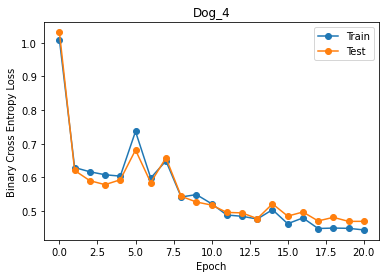

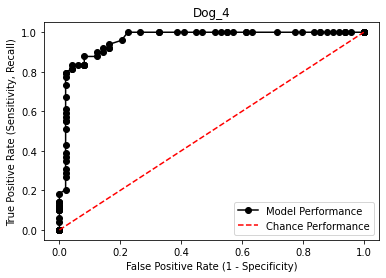

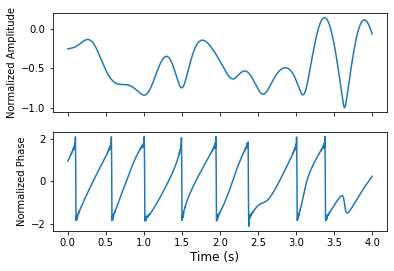

y=1.0, pred=0.6601676940917969


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]


        Train:
            loss=0.958
            acc=0.50
                    interictal, preictal
          precision= 0.49,    0.50
          recall=    0.19,    0.80 
          f1=        0.27,    0.61

        Test:
            loss=0.922
            acc=0.51
                    interictal, preictal
          precision= 0.52,    0.50
          recall=    0.20,    0.81 
          f1=        0.29,    0.62

        Segment:
            loss=0.754
            acc=0.50
                    interictal, preictal
          precision= 0.00,    0.50
          recall=    0.00,    1.00
          f1=        0.00,    0.67
...Training...


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0

        Train:
            loss=0.551
            acc=0.68
                    interictal, preictal
          precision= 0.95,    0.61
          recall=    0.38,    0.98 
          f1=        0.55,    0.75

        Test:
            loss=0.637
            acc=0.58
                    interictal, preictal
          precision= 0.78,    0.54
          recall=    0.21,    0.94 
          f1=        0.33,    0.69


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1

        Train:
            loss=0.336
            acc=0.86
                    interictal, preictal
          precision= 0.91,    0.83
          recall=    0.81,    0.92 
          f1=        0.85,    0.87

        Test:
            loss=0.593
            acc=0.70
                    interictal, preictal
          precision= 0.72,    0.68
          recall=    0.65,    0.75 
          f1=        0.68,    0.71


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 2

        Train:
            loss=0.285
            acc=0.88
                    interictal, preictal
          precision= 0.87,    0.89
          recall=    0.90,    0.86 
          f1=        0.88,    0.88

        Test:
            loss=0.475
            acc=0.77
                    interictal, preictal
          precision= 0.75,    0.79
          recall=    0.81,    0.73 
          f1=        0.78,    0.76


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

New Learnign Rate: 0.0025
Epoch: 3

        Train:
            loss=0.363
            acc=0.87
                    interictal, preictal
          precision= 0.89,    0.86
          recall=    0.85,    0.89 
          f1=        0.87,    0.87

        Test:
            loss=0.555
            acc=0.70
                    interictal, preictal
          precision= 0.69,    0.72
          recall=    0.74,    0.67 
          f1=        0.71,    0.69


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 4

        Train:
            loss=0.266
            acc=0.90
                    interictal, preictal
          precision= 0.87,    0.93
          recall=    0.94,    0.86 
          f1=        0.90,    0.89

        Test:
            loss=0.547
            acc=0.71
                    interictal, preictal
          precision= 0.67,    0.78
          recall=    0.84,    0.59 
          f1=        0.75,    0.67


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 5

        Train:
            loss=0.241
            acc=0.91
                    interictal, preictal
          precision= 0.96,    0.87
          recall=    0.85,    0.96 
          f1=        0.90,    0.91

        Test:
            loss=0.466
            acc=0.79
                    interictal, preictal
          precision= 0.84,    0.75
          recall=    0.72,    0.87 
          f1=        0.78,    0.81


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 6

        Train:
            loss=0.203
            acc=0.93
                    interictal, preictal
          precision= 0.94,    0.93
          recall=    0.93,    0.94 
          f1=        0.93,    0.93

        Test:
            loss=0.447
            acc=0.79
                    interictal, preictal
          precision= 0.78,    0.79
          recall=    0.80,    0.78 
          f1=        0.79,    0.79


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

New Learnign Rate: 0.00125
Epoch: 7

        Train:
            loss=0.369
            acc=0.81
                    interictal, preictal
          precision= 0.73,    0.99
          recall=    0.99,    0.63 
          f1=        0.84,    0.77

        Test:
            loss=0.727
            acc=0.67
                    interictal, preictal
          precision= 0.61,    0.90
          recall=    0.96,    0.39 
          f1=        0.74,    0.54


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 8

        Train:
            loss=0.196
            acc=0.93
                    interictal, preictal
          precision= 0.91,    0.94
          recall=    0.95,    0.91 
          f1=        0.93,    0.93

        Test:
            loss=0.465
            acc=0.78
                    interictal, preictal
          precision= 0.75,    0.82
          recall=    0.84,    0.71 
          f1=        0.79,    0.76


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 9

        Train:
            loss=0.191
            acc=0.93
                    interictal, preictal
          precision= 0.90,    0.96
          recall=    0.97,    0.89 
          f1=        0.93,    0.92

        Test:
            loss=0.440
            acc=0.79
                    interictal, preictal
          precision= 0.75,    0.85
          recall=    0.87,    0.71 
          f1=        0.81,    0.77


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

New Learnign Rate: 0.000625
Epoch: 10

        Train:
            loss=0.297
            acc=0.86
                    interictal, preictal
          precision= 0.99,    0.79
          recall=    0.73,    0.99 
          f1=        0.84,    0.88

        Test:
            loss=0.547
            acc=0.76
                    interictal, preictal
          precision= 0.93,    0.69
          recall=    0.56,    0.96 
          f1=        0.70,    0.80


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 11

        Train:
            loss=0.202
            acc=0.92
                    interictal, preictal
          precision= 0.88,    0.97
          recall=    0.97,    0.87 
          f1=        0.93,    0.92

        Test:
            loss=0.482
            acc=0.77
                    interictal, preictal
          precision= 0.72,    0.86
          recall=    0.89,    0.65 
          f1=        0.80,    0.74


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 12

        Train:
            loss=0.179
            acc=0.94
                    interictal, preictal
          precision= 0.95,    0.94
          recall=    0.94,    0.95 
          f1=        0.94,    0.94

        Test:
            loss=0.395
            acc=0.82
                    interictal, preictal
          precision= 0.82,    0.82
          recall=    0.83,    0.81 
          f1=        0.82,    0.82


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

New Learnign Rate: 0.0003125
Epoch: 13

        Train:
            loss=0.184
            acc=0.94
                    interictal, preictal
          precision= 0.95,    0.92
          recall=    0.92,    0.95 
          f1=        0.94,    0.94

        Test:
            loss=0.410
            acc=0.81
                    interictal, preictal
          precision= 0.82,    0.81
          recall=    0.80,    0.83 
          f1=        0.81,    0.82


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 14

        Train:
            loss=0.174
            acc=0.94
                    interictal, preictal
          precision= 0.94,    0.95
          recall=    0.95,    0.94 
          f1=        0.94,    0.94

        Test:
            loss=0.403
            acc=0.81
                    interictal, preictal
          precision= 0.80,    0.83
          recall=    0.84,    0.78 
          f1=        0.82,    0.81


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

New Learnign Rate: 0.00015625
Epoch: 15

        Train:
            loss=0.174
            acc=0.94
                    interictal, preictal
          precision= 0.95,    0.93
          recall=    0.93,    0.95 
          f1=        0.94,    0.94

        Test:
            loss=0.415
            acc=0.81
                    interictal, preictal
          precision= 0.81,    0.81
          recall=    0.81,    0.80 
          f1=        0.81,    0.81


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

New Learnign Rate: 7.8125e-05
Epoch: 16

        Train:
            loss=0.184
            acc=0.94
                    interictal, preictal
          precision= 0.97,    0.91
          recall=    0.90,    0.97 
          f1=        0.93,    0.94

        Test:
            loss=0.426
            acc=0.81
                    interictal, preictal
          precision= 0.84,    0.78
          recall=    0.76,    0.86 
          f1=        0.80,    0.82


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 17

        Train:
            loss=0.171
            acc=0.94
                    interictal, preictal
          precision= 0.94,    0.95
          recall=    0.95,    0.94 
          f1=        0.94,    0.94

        Test:
            loss=0.415
            acc=0.81
                    interictal, preictal
          precision= 0.79,    0.83
          recall=    0.83,    0.78 
          f1=        0.81,    0.80


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

New Learnign Rate: 3.90625e-05
Epoch: 18

        Train:
            loss=0.174
            acc=0.94
                    interictal, preictal
          precision= 0.96,    0.93
          recall=    0.93,    0.96 
          f1=        0.94,    0.94

        Test:
            loss=0.415
            acc=0.81
                    interictal, preictal
          precision= 0.81,    0.80
          recall=    0.80,    0.82 
          f1=        0.81,    0.81


  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 19

        Train:
            loss=0.172
            acc=0.94
                    interictal, preictal
          precision= 0.93,    0.96
          recall=    0.96,    0.93 
          f1=        0.94,    0.94

        Test:
            loss=0.418
            acc=0.81
                    interictal, preictal
          precision= 0.78,    0.84
          recall=    0.85,    0.76 
          f1=        0.81,    0.80
...Evaluating...


  0%|          | 0/30 [00:00<?, ?it/s]


        Segment:
            loss=0.312
            acc=0.93
                    interictal, preictal
          precision= 0.88,    1.00
          recall=    1.00,    0.87
          f1=        0.94,    0.93
ROCAUC= 0.991111111111111


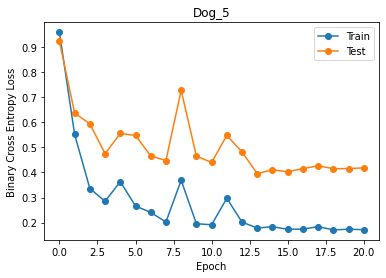

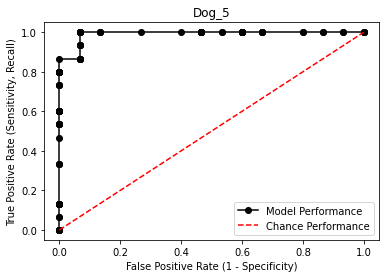

In [113]:
subs = ["Patient_1", "Patient_2", "Dog_1", "Dog_2", "Dog_3", "Dog_4", "Dog_5"]
nums_segs = [18, 18, 24, 42, 72, 97, 30]
nums_channels = [30, 48, 32, 32, 32, 32, 30]
ys, true_preds, aucs = [], [], []
for sub, num_segs, num_channels in zip(subs, nums_segs, nums_channels):
    print(sub)
    if True:
        y, true_pred, auc = generate_model(sub, num_segs, num_channels)
    else:
        model = torch.load(sub+"Model.pt")
        y, true_pred, auc = final_eval(sub, model)
    ys.append(y)
    true_preds.append(true_pred)
    aucs.append(auc)

Aggregate and Average Evaluation Statistics

Average ROCAUC = 0.961 +/- 0.046

Aggregate Segment-wise
    ROCAUC: 0.95, Accuracy: 0.86
        Interictal, Preictal
Precision: 0.86,  0.87
Recall:    0.87,  0.86
F1 Score:  0.86,  0.86



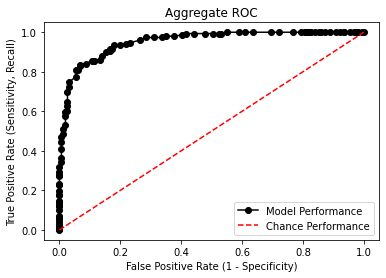

In [114]:
avg_auc = np.mean(aucs)
std_auc = np.std(aucs)
print("Average ROCAUC = {:.3f} +/- {:.3f}".format(avg_auc, std_auc))

agg_ys, agg_preds = [], []
for sub_ys, sub_preds in zip(ys, true_preds):
    for y, pred in zip(sub_ys, sub_preds):
        agg_ys.append(y)
        agg_preds.append(pred)
agg_ys = np.array(agg_ys)
round_preds = np.round(agg_preds)
acc = np.sum(agg_ys == round_preds) / len(agg_ys)
prec, recall, f1, _ = prf(agg_ys, round_preds)
        
thresholds = np.linspace(0, 1, 101)
tprs, fprs, auc = roc_eval_loop(agg_ys, agg_preds, thresholds)
print("""
Aggregate Segment-wise
    ROCAUC: {:.2f}, Accuracy: {:.2f}
        Interictal, Preictal
Precision: {:.2f},  {:.2f}
Recall:    {:.2f},  {:.2f}
F1 Score:  {:.2f},  {:.2f}
""".format(auc, acc, prec[0], prec[1], recall[0], recall[1], f1[0], f1[1]))

plt.figure()
plt.hold = True
plt.plot(fprs, tprs, 'ko-')
plt.plot(fprs, fprs, 'r--')
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.legend(["Model Performance", "Chance Performance"])
_ = plt.title("Aggregate ROC")

In [ ]:
()